### 전처리 후 feature 대상으로 LGBM 학습  
(Developed from dacon_etri_base_mod3_1.ipynb)
* 전처리 대상  
> Activity (2. MinMaxScaler)  
> Ambient (MaxAbsScaler)
> mLight (...)

* (+) GridSearch 대신 Optuna 사용 (병렬화 용이)


In [1]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530

# kmjng
submission_folder = '/home/user/miniconda3/envs/gpu_conda/src/lifelog-sleep-ictc-2025/minjeong/submission/'

# # kmjng-nb
# submission_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/lifelog-sleep-ictc-2025/minjeong/submission'

submission_file = f'submission_final_mod3_1_{timestamp}.csv'

# kmjng
base_folder =  '/home/user/miniconda3/envs/gpu_conda/src/data/ETRI_lifelog_dataset'

# # kmjng-nb
# base_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/data/ETRI_lifelog_dataset'

folder = '/ch2025_data_items'

data_dir = base_folder + folder 




In [2]:

import numpy as np 
import pandas as pd 
import glob 
import random 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
import warnings
warnings.filterwarnings('ignore') 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import torch
import tensorflow as tf 


2025-06-01 23:31:42.768330: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 23:31:42.831573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 23:31:43.110264: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 23:31:43.112045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-01 23:31:44.281630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
# seed 고정 
SD = 42 
random.seed(SD) 
np.random.seed(SD) 
os.environ['PYTHONHASHSEED'] = str(SD)
tf.random.set_seed(SD)  # TensorFlow 시드 설정

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

In [4]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)
✅ Loaded: mUsageStats, shape = (45197, 3)


In [5]:
# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 

In [6]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


In [7]:
# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [8]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

In [9]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 

### Avitvity 전처리(2)

In [10]:
mActivity_df2.columns

Index(['subject_id', 'date', 'activity_0_ratio', 'activity_1_ratio',
       'activity_2_ratio', 'activity_3_ratio', 'activity_4_ratio',
       'activity_5_ratio', 'activity_6_ratio', 'activity_7_ratio',
       'activity_8_ratio', 'dominant_activity', 'num_unique_activities'],
      dtype='object')

In [11]:
mActivity_df2['activity_2_ratio'].value_counts(ascending=False)

activity_2_ratio
0    700
Name: count, dtype: int64

In [12]:
mActivity_df2.drop(columns=['activity_2_ratio', 'activity_5_ratio','activity_6_ratio'], axis=1, inplace=True) # 2번('bicycle'), 5번('tilting'), 6번 모두 0

In [13]:
mActivity_df2.head(3)

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_3_ratio,activity_4_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.125176,0.001406,0.672293,0.157525,0.043601,0.0,3,5
1,id01,2024-06-27,0.146528,0.000000,0.611111,0.220833,0.021528,0.0,3,4
2,id01,2024-06-28,0.111806,0.000694,0.861806,0.000694,0.025000,0.0,3,5


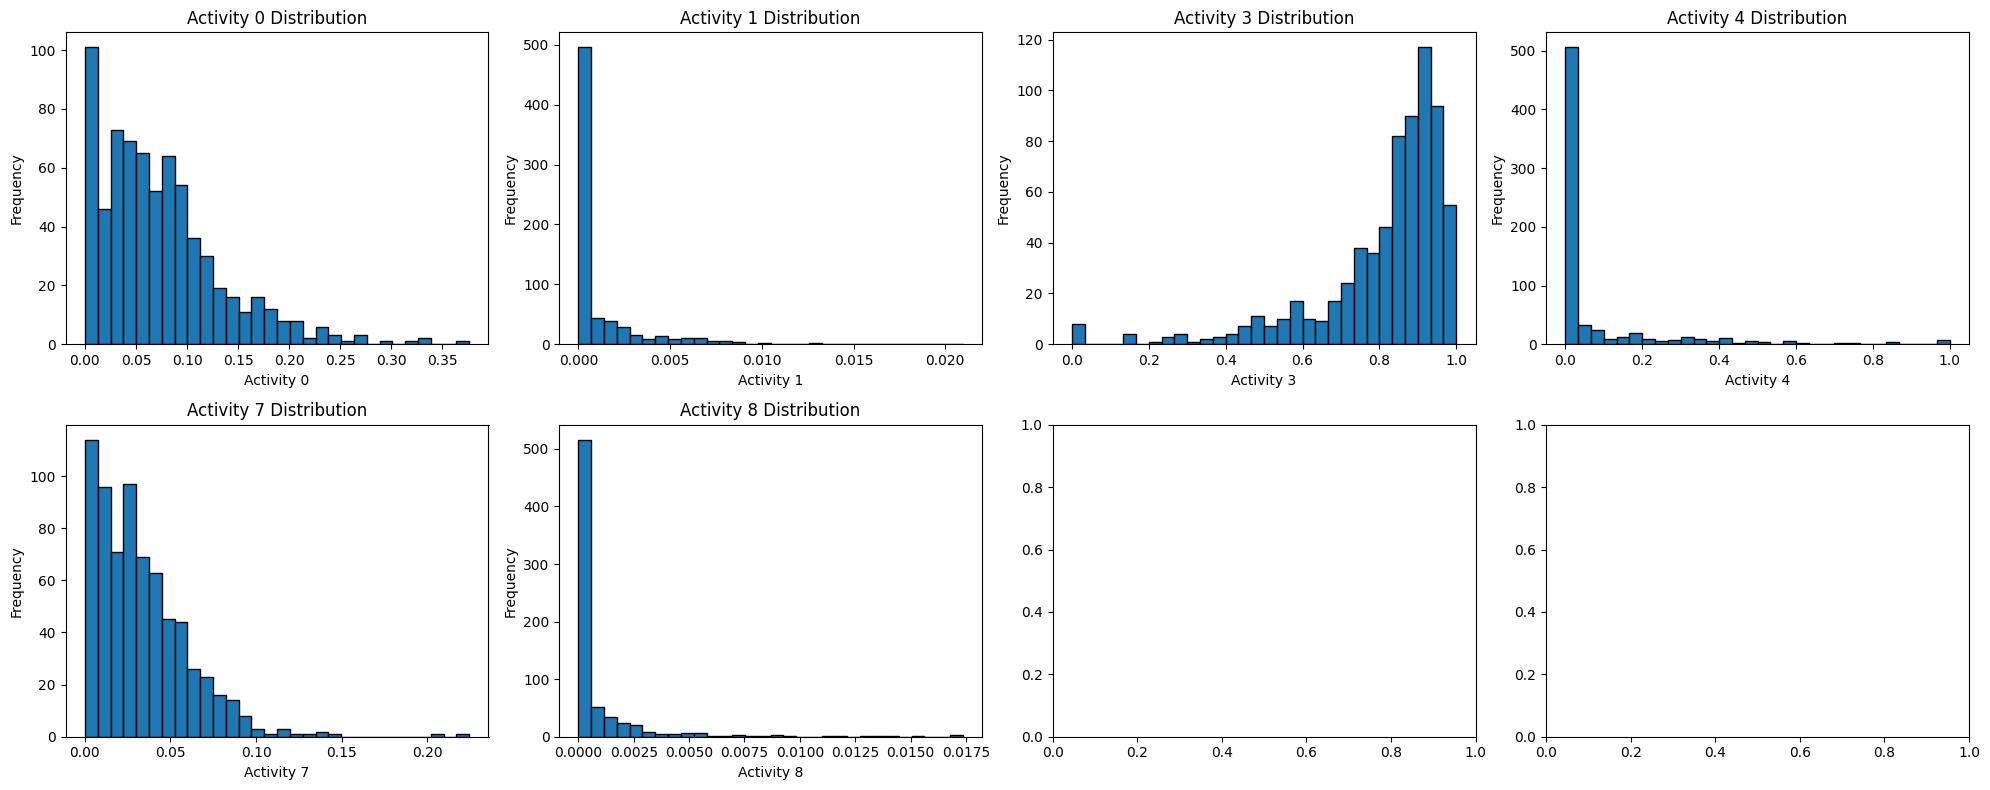

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np

df = mActivity_df2.copy()



# 히스토그램을 그릴 컬럼 이름 리스트 생성
activity_columns = [f'activity_{i}_ratio' for i in [0,1,3,4,7,8]]

# subplot 개수 계산
num_plots = len(activity_columns)

# subplot을 위한 행과 열 개수 결정 (예: 최대 4열로 배치)
num_cols = min(num_plots, 4)
num_rows = int(np.ceil(num_plots / num_cols))

# subplot 생성
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten() # 2차원 axes 배열을 1차원으로 펼쳐서 인덱싱 용이하게 함

# 각 activity 컬럼에 대해 히스토그램 그리기
for i, col in enumerate(activity_columns):
    if i < num_plots:
        axes[i].hist(df[col], bins=30, edgecolor='black')
        axes[i].set_title(f'{col.replace("_ratio", "").replace("_", " ").title()} Distribution')
        axes[i].set_xlabel(col.replace("_ratio", "").replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
    else:
        # 더 이상 그릴 그래프가 없으면 해당 subplot 숨기기
        fig.delaxes(axes[i])

# subplot 간 간격 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()

https://shine2gether.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%82%AC%EC%9D%B4%EC%96%B8%EC%8A%A4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A0%84%EC%B2%98%EB%A6%AC

In [15]:
mActivity_df3 = mActivity_df2.copy()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
epsilon = 1e-6

# Activity 0: sqrt 변환 (Positive Skew 완화)
mActivity_df3['activity_0_ratio'] = np.sqrt(mActivity_df2['activity_0_ratio'])

# Activity 1: Arcsin 변환 (0에 몰린 비율 데이터)
mActivity_df3['activity_1_ratio'] = np.arcsin(np.sqrt(mActivity_df2['activity_1_ratio'].clip(0, 1))) # 0~1 범위 클리핑

# Activity 3:  (Negative Skew 완화)
max_3 = (mActivity_df2['activity_3_ratio']+1).max()
mActivity_df3['activity_3_ratio'] = np.sqrt(max_3 - mActivity_df2['activity_3_ratio'])

# Activity 4: sqrt 변환 (Positive Skew 완화)
mActivity_df3['activity_4_ratio'] = np.sqrt(mActivity_df2['activity_4_ratio'])

# Activity 7: sqrt 변환 (Positive Skew 완화)
mActivity_df3['activity_7_ratio'] = np.sqrt(mActivity_df2['activity_7_ratio'])

# Activity 8: Arcsin 변환 (0에 몰린 비율 데이터)
mActivity_df3['activity_8_ratio'] = np.arcsin(np.sqrt(mActivity_df2['activity_8_ratio'].clip(0, 1))) # 0~1 범위 클리핑

mActivity_df3.head(3)

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_3_ratio,activity_4_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.353802,0.037512,1.152262,0.396894,0.208807,0.0,3,5
1,id01,2024-06-27,0.382789,0.000000,1.178511,0.469929,0.146723,0.0,3,4
2,id01,2024-06-28,0.334373,0.026355,1.066862,0.026352,0.158114,0.0,3,5


In [16]:
mActivity_df3['activity_3_ratio'].describe()

count    700.000000
mean       1.086685
std        0.076759
min        1.000000
25%        1.036747
50%        1.063439
75%        1.112417
max        1.414214
Name: activity_3_ratio, dtype: float64

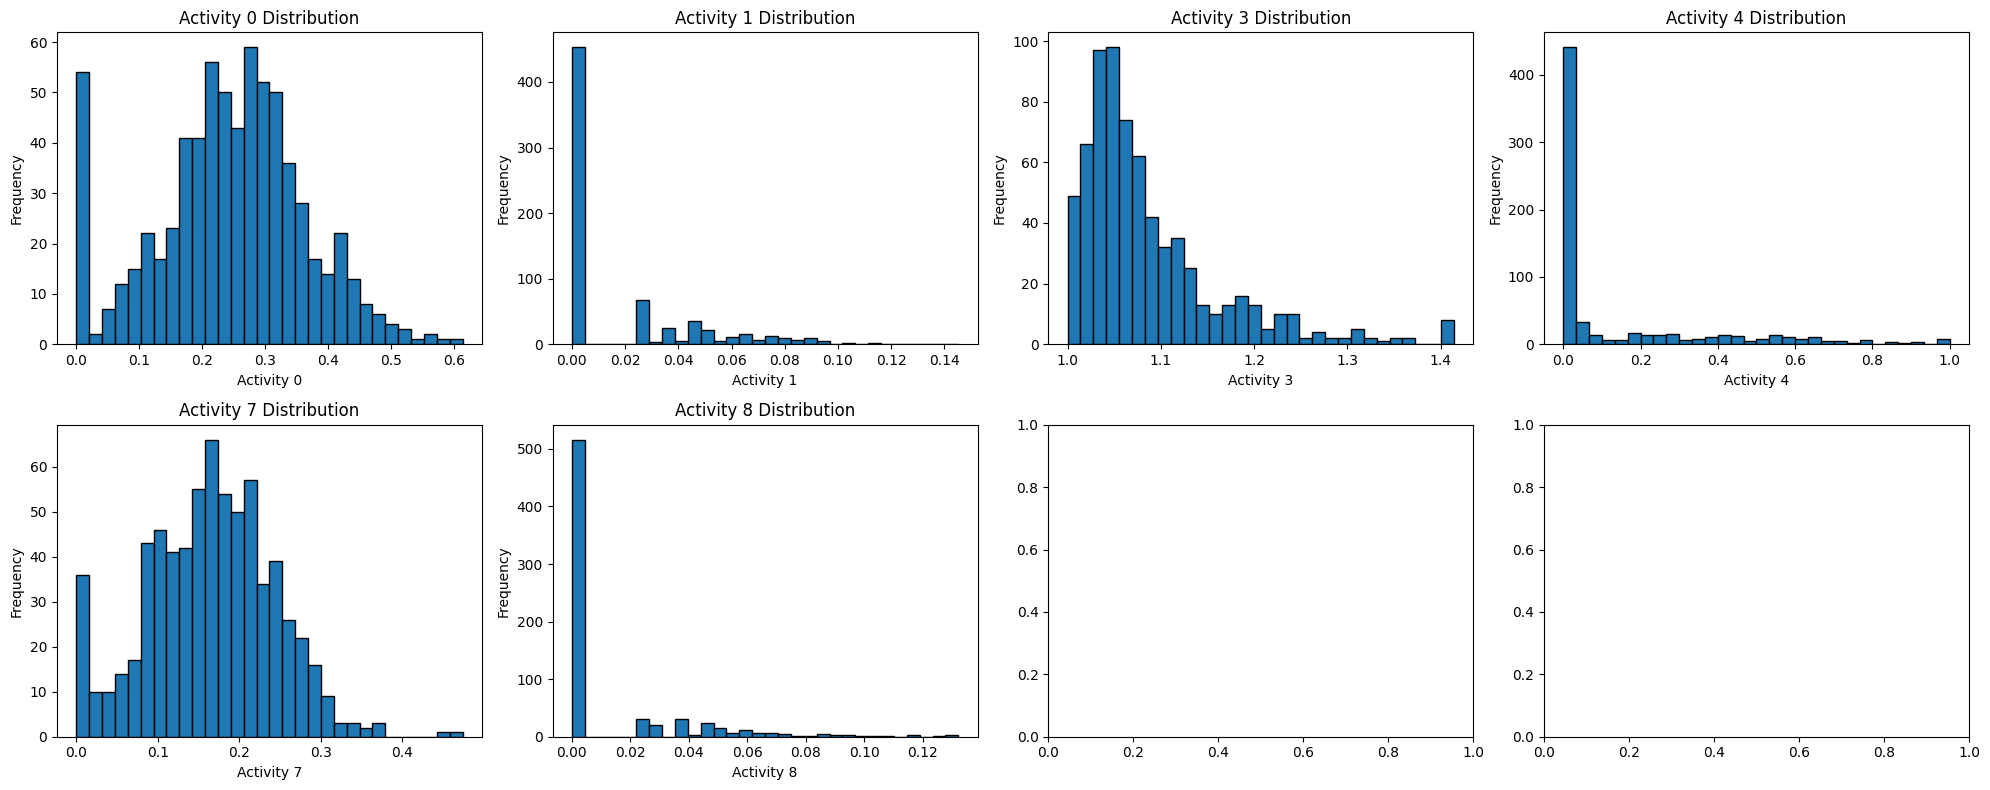

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np

df = mActivity_df3.copy()



# 히스토그램을 그릴 컬럼 이름 리스트 생성
activity_columns = [f'activity_{i}_ratio' for i in [0,1,3,4,7,8]]

# subplot 개수 계산
num_plots = len(activity_columns)

# subplot을 위한 행과 열 개수 결정 (예: 최대 4열로 배치)
num_cols = min(num_plots, 4)
num_rows = int(np.ceil(num_plots / num_cols))

# subplot 생성
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten() # 2차원 axes 배열을 1차원으로 펼쳐서 인덱싱 용이하게 함

# 각 activity 컬럼에 대해 히스토그램 그리기
for i, col in enumerate(activity_columns):
    if i < num_plots:
        axes[i].hist(df[col], bins=30, edgecolor='black')
        axes[i].set_title(f'{col.replace("_ratio", "").replace("_", " ").title()} Distribution')
        axes[i].set_xlabel(col.replace("_ratio", "").replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
    else:
        # 더 이상 그릴 그래프가 없으면 해당 subplot 숨기기
        fig.delaxes(axes[i])

# subplot 간 간격 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()

### Ambience 

In [18]:
# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df2= process_mAmbience_top10(mAmbience_df) 

In [22]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) 


In [24]:
# Ambience 전처리 (MaxAbsScaler - 0으로 치우친 데이터) 
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
mAmbience_df2['Inside_small_room_scaled'] = scaler.fit_transform(mAmbience_df2[['Inside, small room']]).round(3)
mAmbience_df2['Speech_scaled'] = scaler.fit_transform(mAmbience_df2[['Speech']]).round(3)
mAmbience_df2['Silence_scaled'] = scaler.fit_transform(mAmbience_df2[['Silence']]).round(3)
mAmbience_df2['Music_scaled'] = scaler.fit_transform(mAmbience_df2[['Music']]).round(3)
mAmbience_df2['Narration_monologue_scaled'] = scaler.fit_transform(mAmbience_df2[['Narration, monologue']]).round(3)
mAmbience_df2['Child_speech_kid_speaking_scaled'] = scaler.fit_transform(mAmbience_df2[['Child speech, kid speaking']]).round(3)
mAmbience_df2['Conversation_scaled'] = scaler.fit_transform(mAmbience_df2[['Conversation']]).round(3)
mAmbience_df2['Speech_synthesizer_scaled'] = scaler.fit_transform(mAmbience_df2[['Speech synthesizer']]).round(3)
mAmbience_df2['Shout_scaled'] = scaler.fit_transform(mAmbience_df2[['Shout']]).round(3)
mAmbience_df2['Babbling_scaled'] = scaler.fit_transform(mAmbience_df2[['Babbling']]).round(3)
mAmbience_df2['others_scaled'] = scaler.fit_transform(mAmbience_df2[['others']]).round(3)

mAmbience_df3  = mAmbience_df2[['subject_id', 'date', 'Inside_small_room_scaled', 
                                'Speech_scaled', 'Silence_scaled', 'Music_scaled', 'Narration_monologue_scaled',
                                'Child_speech_kid_speaking_scaled', 'Conversation_scaled',
                                'Speech_synthesizer_scaled','Shout_scaled', 'Babbling_scaled',
                                'others_scaled'
                                ]]

In [25]:
def process_mBle(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble'] 
        rssi_list = [] 
        class_0_cnt = 0 
        class_other_cnt = 0 
        for device in entry: 
            try: 
                rssi = int(device['rssi']) 
                rssi_list.append(rssi) 
                if str(device['device_class']) == '0': 
                    class_0_cnt += 1 
                else: 
                    class_other_cnt += 1 
            except: 
                continue # malformed record 
        feature = { 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'device_class_0_cnt': class_0_cnt, 
            'device_class_others_cnt': class_other_cnt, 
            'device_count': len(rssi_list), 
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan, 
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan, 
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan, 
        } 
        features.append(feature) 
    return pd.DataFrame(features) 

In [26]:
def summarize_mBle_daily(df): 
    # row 단위 BLE feature 추출 
    df = process_mBle(df) 
    # 하루 단위로 cnt 합치기 
    grouped = df.groupby(['subject_id', 'date']).agg({ 
        'device_class_0_cnt': 'sum', 
        'device_class_others_cnt': 'sum', 
        'rssi_mean': 'mean', 
        'rssi_min': 'min', 
        'rssi_max': 'max', 
    }).reset_index() 
    # 총합 구해서 비율 계산 
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt'] 
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan) 
    # 필요 없는 원래 cnt 컬럼 제거 
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True) 
    return grouped 

mBle_df2 = summarize_mBle_daily(mBle_df) 

In [27]:
def process_mGps(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps'] 
        altitudes = [] 
        latitudes = [] 
        longitudes = [] 
        speeds = [] 
        for entry in gps_list: 
            try: 
                altitudes.append(float(entry['altitude'])) 
                latitudes.append(float(entry['latitude'])) 
                longitudes.append(float(entry['longitude'])) 
                speeds.append(float(entry['speed'])) 
            except: 
                continue 
        features.append({ 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan, 
            'latitude_std': np.std(latitudes) if latitudes else np.nan, 
            'longitude_std': np.std(longitudes) if longitudes else np.nan, 
            'speed_mean': np.mean(speeds) if speeds else np.nan, 
            'speed_max': np.max(speeds) if speeds else np.nan, 
            'speed_std': np.std(speeds) if speeds else np.nan, 
        }) 
    return pd.DataFrame(features) 

In [28]:
m_Gps_df2 = process_mGps(mGps_df) 
m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({ 
    'altitude_mean': 'mean', 
    'latitude_std': 'mean', 
    'longitude_std': 'mean', 
    'speed_mean': 'mean', 
    'speed_max': 'max', 
    'speed_std': 'mean' 
}).reset_index() 

In [29]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

In [30]:
def process_mScreenStatus(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_screen_use'].values 
        ratio_on = status.mean() 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        durations = [] 
        current = 0 
        for val in status: 
            if val == 1: 
                current += 1 
            elif current > 0: 
                durations.append(current) 
                current = 0 
        if current > 0: 
            durations.append(current) 
        features.append({ 
            'subject_id': subj, 
            'date': date, 
            'screen_on_ratio': ratio_on, 
            'screen_on_transitions': transitions, 
            'screen_on_duration_avg': np.mean(durations) if durations else 0, 
            'screen_on_duration_max': np.max(durations) if durations else 0, 
        }) 
    return pd.DataFrame(features) 

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df) 


In [31]:
top_apps = [ 
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', 
    '성경일독Q', 'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
] 

def process_mUsageStats(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        app_time = {app: 0 for app in top_apps} 
        others_time = 0 
        for row in group['m_usage_stats']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for entry in parsed: 
                app = entry.get('app_name') 
                time = entry.get('total_time', 0) 
                if app in top_apps: 
                    app_time[app] += int(time) 
                else: 
                    others_time += int(time) 
        feature = { 
            'subject_id': subj, 
            'date': date, 
            'others_time': others_time 
        } 
        # 각 앱별 컬럼 추가 
        feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
        features.append(feature) 
    return pd.DataFrame(features) 

mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

In [32]:

def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        rssi_all = [] 
        for row in group['m_wifi']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for ap in parsed: 
                try: 
                    rssi = int(ap['rssi']) 
                    rssi_all.append(rssi) 
                except: 
                    continue 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
            'wifi_detected_cnt': len(rssi_all) 
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 

In [33]:

def get_time_block(hour): 
    if 0 <= hour < 6: 
        return 'early_morning' 
    elif 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    else: 
        return 'evening' 

def process_wHr_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            if not hr_all: 
                continue 
            above_100 = [hr for hr in hr_all if hr > 100] 
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all) 
            block_stats[f'hr_{block}_std'] = np.std(hr_all) 
            block_stats[f'hr_{block}_max'] = np.max(hr_all) 
            block_stats[f'hr_{block}_min'] = np.min(hr_all) 
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wHr_df2 = process_wHr_by_timeblock(wHr_df) 

In [34]:

def process_wLight_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            lux = block_group['w_light'].dropna().values 
            if len(lux) == 0: 
                continue 
            block_stats[f'wlight_{block}_mean'] = np.mean(lux) 
            block_stats[f'wlight_{block}_std'] = np.std(lux) 
            block_stats[f'wlight_{block}_max'] = np.max(lux) 
            block_stats[f'wlight_{block}_min'] = np.min(lux) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [35]:
def process_wPedo(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = df.groupby(['subject_id', 'date']).agg({ 
        'step': 'sum', 
        'step_frequency': 'mean', 
        'distance': 'sum', 
        'speed': ['mean', 'max'], 
        'burned_calories': 'sum' 
    }).reset_index() 
    # 컬럼 이름 정리 
    summary.columns = ['subject_id', 'date', 'step_sum', 'step_frequency_mean', 'distance_sum', 'speed_mean', 'speed_max', 'burned_calories_sum'] 
    return summary 

wPedo_df2 = process_wPedo(wPedo_df) 

In [36]:

from functools import reduce 
df_list = [ 
    mACStatus_df2, 
    mActivity_df3, # mActivity_df3, #  mActivity_df2 [★]
    mAmbience_df3, # mAmbience_df2, 
    mBle_df2, 
    m_Gps_df2, 
    mLight_df2, 
    mScreenStatus_df2, 
    mUsageStats_df2, 
    mWifi_df2, 
    wHr_df2, 
    wLight_df2, 
    wPedo_df2 
] 

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list) 


* train, test

In [37]:

# metrics_train의 lifelog_date → datetime.date 형으로 변환 
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date 

# merged_df의 date도 변환 
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date 

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기 
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'}) 

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함 
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner') 

# 3. test_df: metrics_train에 없는 (subject_id, date) 
merged_keys = merged_df[['subject_id', 'date']] 
train_keys = metrics_train_renamed[['subject_id', 'date']] 
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True) 
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge']) 
test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left') 


In [38]:

# ✅ 타겟 리스트 
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3'] 
target_multiclass = 'S1' 

# ✅ feature 준비 
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']) 
X.fillna(0, inplace=True) # 결측값 처리 

test_X = test_df.drop(columns=['subject_id', 'date']) 
test_X.fillna(0, inplace=True) 


In [39]:

# 컬럼 이름에서 특수 문자 제거/변환 
def sanitize_column_names(df): 
    df.columns = ( 
        df.columns 
        .str.replace(r"[^\w]", "_", regex=True) # 특수문자 → _ 
        .str.replace(r"__+", "_", regex=True) # 연속된 _ 제거 
        .str.strip("_") # 앞뒤 _ 제거 
    ) 
    return df 

# 모든 입력에 적용 
X = sanitize_column_names(X) 
test_X = sanitize_column_names(test_X) 

### 모델링 시작 

In [40]:
# 모든 특성에 대해 모델링 진행 
X_selected = X.copy()
test_X_selected = test_X.copy()

In [41]:
# LightGBM 라이브러리 임포트
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# GridSearch를 위한 교차 검증 설정
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LightGBM 기본 파라미터 설정
lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}


In [42]:
# -------------------------------- # 
# [그리드서치 적용 X] 
# 이진 분류
binary_preds_selected = {}
binary_models_selected = {}  # 모델 객체 저장용 딕셔너리 (for Feature-Importance)


for col in targets_binary:
    print(f">> {col} 변수 진행 중..")
    y = train_df[col]
    # 이진 분류용 파라미터 조정
    binary_params = lgbm_params.copy()
    binary_params['objective'] = 'binary'
    
    model = LGBMClassifier(**binary_params)
    model.fit(X_selected, y)
    binary_preds_selected[col] = model.predict(test_X_selected)
    binary_models_selected[col] = model  # 여기에 모델 저장

# 다중 분류 (S1)
print(">> S1 변수 진행 중..")

y_multi = train_df['S1']
# 다중 분류용 파라미터 설정 (클래스 수 추가)
multiclass_params = lgbm_params.copy()
multiclass_params['num_class'] = len(y_multi.unique())

model_s1_selected = LGBMClassifier(**multiclass_params)
model_s1_selected.fit(X_selected, y_multi)  
multiclass_pred_selected = model_s1_selected.predict(test_X_selected)

>> Q1 변수 진행 중..
>> Q2 변수 진행 중..
>> Q3 변수 진행 중..
>> S2 변수 진행 중..
>> S3 변수 진행 중..
>> S1 변수 진행 중..


### Feature Importance (for binary, multi classification)

* Binary 

In [43]:
import matplotlib.font_manager as fm
# sudo apt update
# sudo apt install fonts-nanum
# sudo fc-cache -fv
# 나눔고딕 폰트 경로 설정 (한글인코딩)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

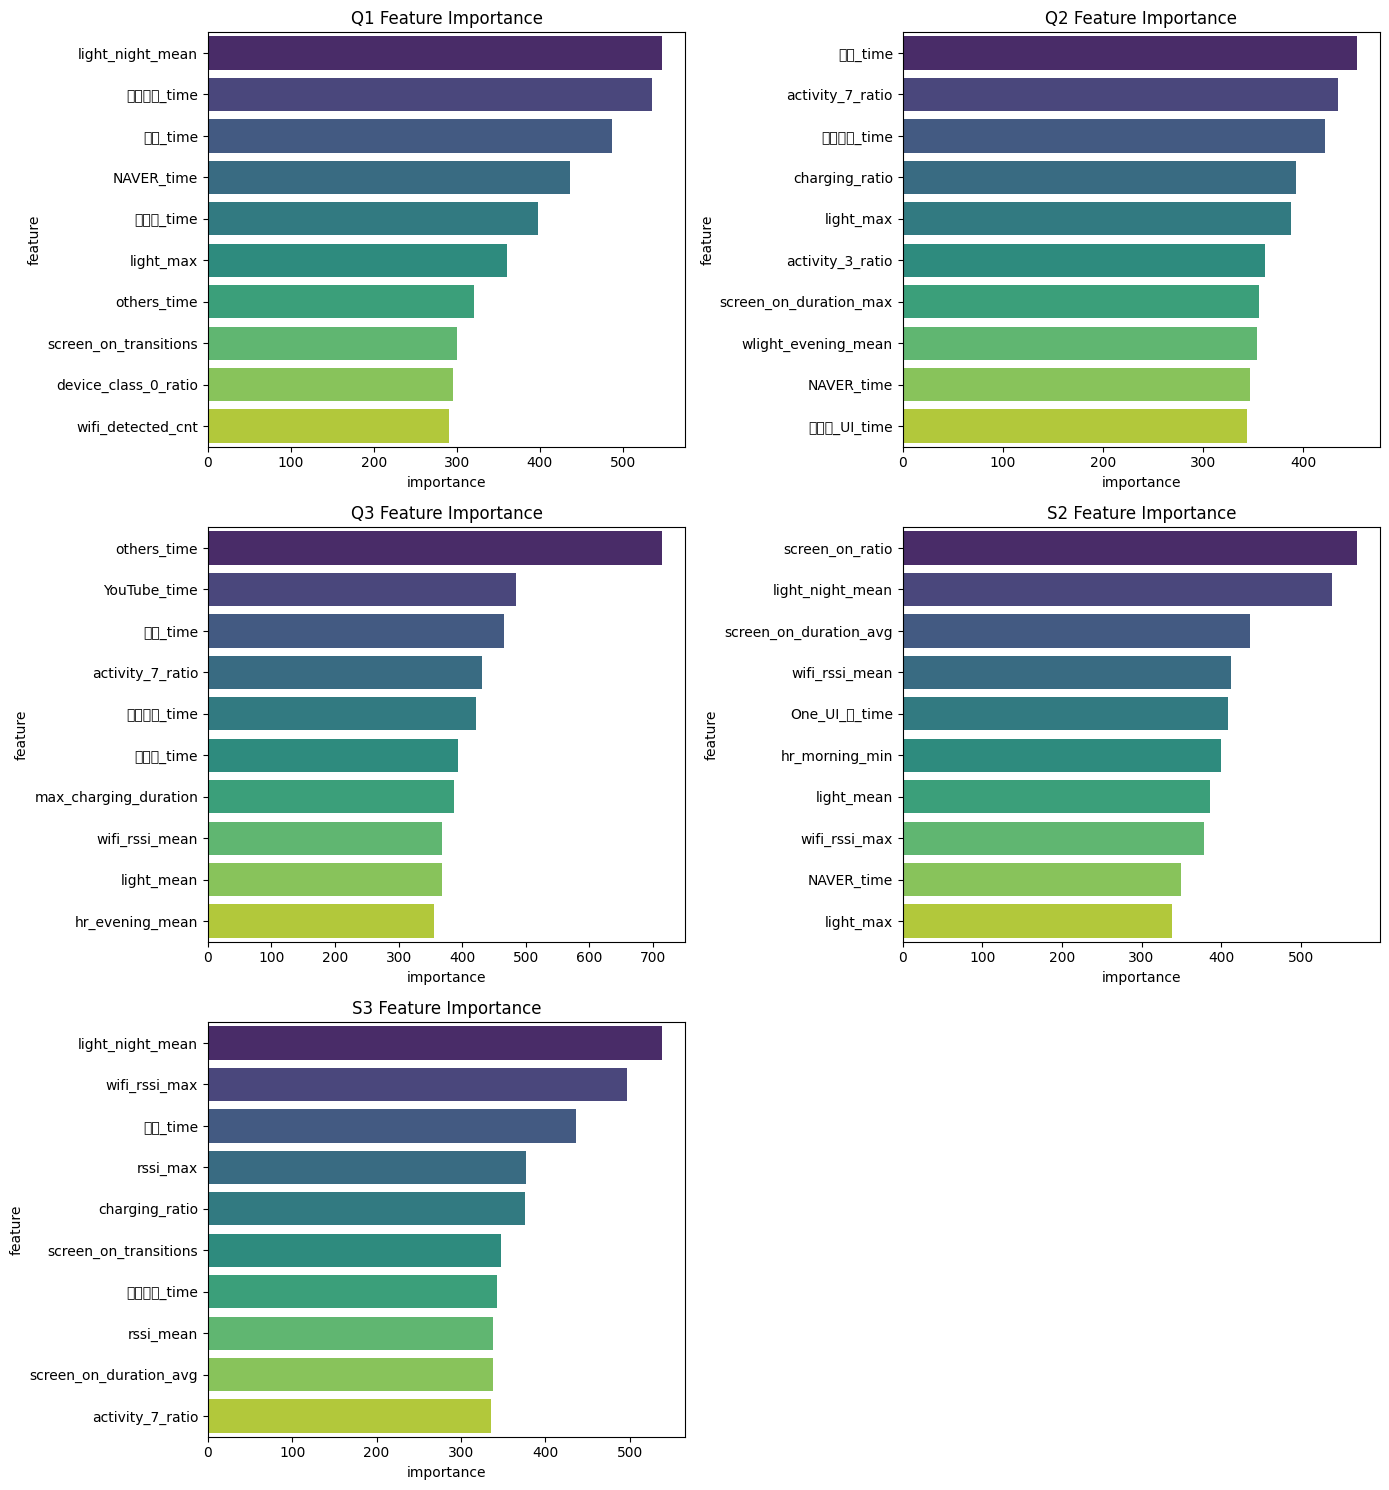

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

top_features_binary = set() # feature top 10 

# subplot 수 계산
n_models = len(binary_models_selected)
n_cols = 2  # 한 줄에 두 개씩
n_rows = math.ceil(n_models / n_cols)

# subplot 생성
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()  # 2D -> 1D 배열로 변환

for idx, (col_name, model) in enumerate(binary_models_selected.items()):
    importance_df = pd.DataFrame({
        'feature': X_selected.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)  # 상위 10개만 표시

    # 📌 상위 feature들을 set에 추가
    top_features_binary.update(importance_df['feature'].unique())


    sns.barplot(
        x='importance', y='feature', 
        data=importance_df, ax=axes[idx], palette='viridis' 
    )
    axes[idx].set_title(f'{col_name} Feature Importance')

# 남은 빈 subplot 제거
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [45]:
# 📌 결과 출력
top_features_binary = list(top_features_binary)
print("📌 전체 모델에서 등장한 상위 10개 feature들의 unique 목록:")
print(top_features_binary) 
print("📌 feature unique 갯수:")
print(len(top_features_binary))


📌 전체 모델에서 등장한 상위 10개 feature들의 unique 목록:
['screen_on_duration_avg', 'wlight_evening_mean', 'device_class_0_ratio', 'screen_on_ratio', 'wifi_rssi_mean', 'screen_on_transitions', 'One_UI_홈_time', 'light_mean', 'others_time', 'YouTube_time', 'hr_evening_mean', 'hr_morning_min', '카카오톡_time', 'screen_on_duration_max', '메시지_time', 'rssi_mean', 'rssi_max', 'light_night_mean', '통화_time', 'activity_3_ratio', 'wifi_rssi_max', 'wifi_detected_cnt', 'charging_ratio', '시스템_UI_time', 'activity_7_ratio', 'max_charging_duration', 'light_max', 'NAVER_time']
📌 feature unique 갯수:
28


* Multi (S1)

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

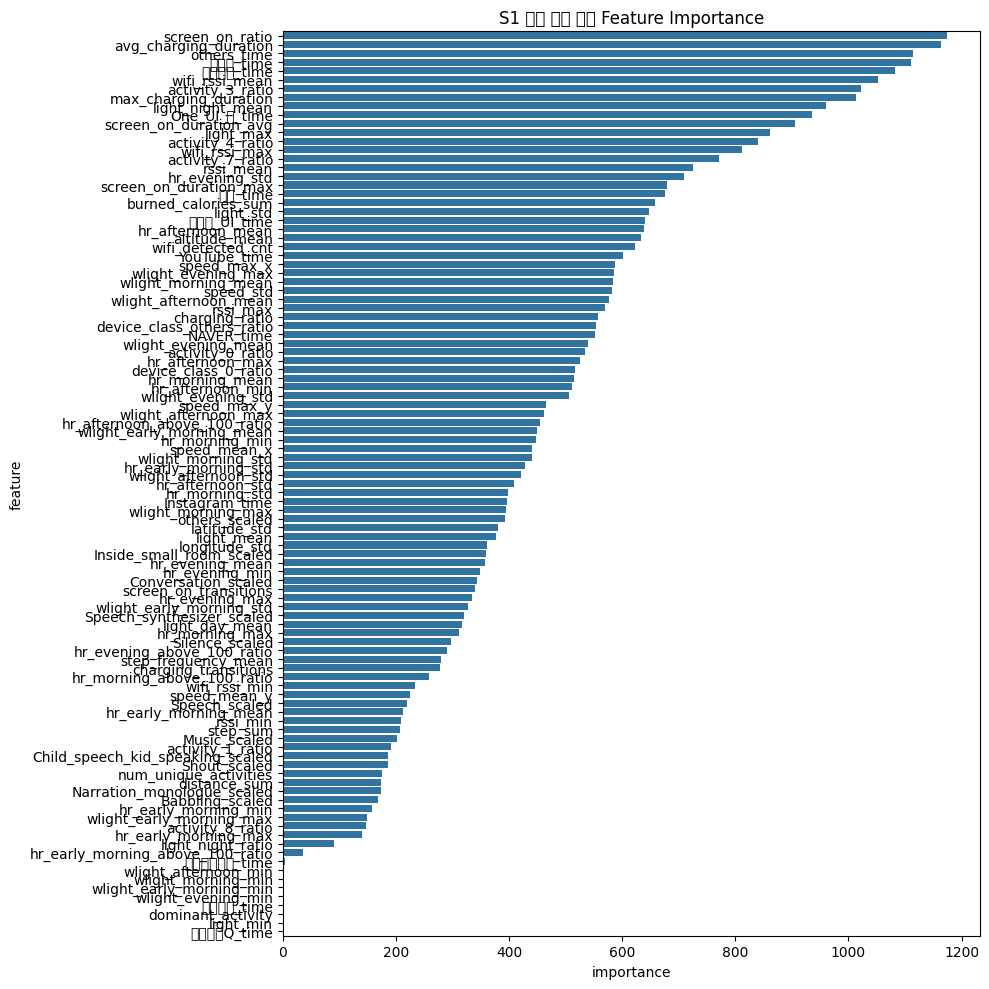

In [46]:
# 중요도 추출  
fi_multi = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': model_s1_selected.feature_importances_
}).sort_values('importance', ascending=False)

# top 10 features
fi_multi_10 = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': model_s1_selected.feature_importances_
}).sort_values('importance', ascending=False).head(10)


# 시각화
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=fi_multi)
plt.title('S1 다중 분류 모델 Feature Importance')
plt.tight_layout()
plt.show()


In [47]:
# 📌 결과 출력
top_features_multi = fi_multi_10['feature'].tolist()

print("📌 다중분류(S1) 모델에서 등장한 상위 10개 feature들의 unique 목록:")
print(top_features_multi)  # 정렬은 선택사항
print("📌 feature unique 갯수:")
print(len(top_features_multi))


📌 다중분류(S1) 모델에서 등장한 상위 10개 feature들의 unique 목록:
['screen_on_ratio', 'avg_charging_duration', 'others_time', '메시지_time', '카카오톡_time', 'wifi_rssi_mean', 'activity_3_ratio', 'max_charging_duration', 'light_night_mean', 'One_UI_홈_time']
📌 feature unique 갯수:
10


* [★] 선정된 Feature 

In [48]:
important_features = list(set(top_features_binary + top_features_multi))
print("갯수 :", len(important_features))
print(important_features)


갯수 : 29
['screen_on_duration_avg', 'wlight_evening_mean', 'device_class_0_ratio', 'screen_on_ratio', 'wifi_rssi_mean', 'screen_on_transitions', 'One_UI_홈_time', 'others_time', 'YouTube_time', 'hr_evening_mean', 'hr_morning_min', '카카오톡_time', 'screen_on_duration_max', 'rssi_mean', '메시지_time', 'rssi_max', 'light_night_mean', '통화_time', 'activity_3_ratio', 'wifi_rssi_max', 'wifi_detected_cnt', 'charging_ratio', '시스템_UI_time', 'avg_charging_duration', 'NAVER_time', 'activity_7_ratio', 'max_charging_duration', 'light_max', 'light_mean']


In [49]:


# 선택된 특성만으로 데이터셋 구성
X_selected = X[important_features]
test_X_selected = test_X[important_features]


### feature에 대한 모델링 및 그리드서치

In [50]:
# ##################
# ## Optuna 
# ##################
# GPU 최적화된 LightGBM 하이퍼파라미터 튜닝

import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import numpy as np
import time

# GPU 최적화 파라미터 설정
def get_optimized_gpu_params():
    """GPU 성능을 최대화하는 LightGBM 파라미터"""
    return {
        'device': 'gpu',
        'gpu_use_dp': True,  # 더블 정밀도 사용 (정확도 향상)
        'num_gpu': 1,  # 사용할 GPU 개수
        'random_state': 42,
        'verbosity': -1,
        'n_jobs': 1,  # GPU 사용시 반드시 1
        'force_row_wise': True,  # GPU에서 더 빠른 학습
        'histogram_pool_size': -1,  # 메모리 최적화
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

# Optuna를 사용한 효율적인 하이퍼파라미터 최적화
def optimize_lgbm_with_optuna(X, y, objective_type='binary', n_trials=50):
    """
    Optuna를 사용한 효율적인 하이퍼파라미터 최적화
    GridSearch보다 3-5배 빠름
    """
    
    def objective(trial):
        # 하이퍼파라미터 범위 설정 (더 좁은 범위로 빠른 탐색)
        params = get_optimized_gpu_params()
        
        # 중요한 파라미터만 최적화
        params.update({
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100, step=10),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0, step=0.1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0, step=0.1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0, step=0.1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0, step=0.1),
        })
        
        if objective_type == 'binary':
            params['objective'] = 'binary'
            model = lgb.LGBMClassifier(**params)
            scoring = 'f1'
        else:
            params['objective'] = 'multiclass'
            params['num_class'] = len(np.unique(y))
            model = lgb.LGBMClassifier(**params)
            scoring = 'f1_macro'
        
        # 더 빠른 교차검증 (3-fold 사용)
        try:
            scores = cross_val_score(model, X, y, cv=3, scoring=scoring, n_jobs=1)
            return scores.mean()
        except Exception as e:
            print(f"Trial failed: {e}")
            return 0.0
    
    # Optuna 최적화 실행
    study = optuna.create_study(direction='maximize', 
                              sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params

# 배치 예측으로 속도 향상
def batch_predict(model, X_test, batch_size=10000):
    """
    대용량 데이터를 배치로 나누어 예측하여 메모리 효율성 향상
    """
    n_samples = X_test.shape[0]
    predictions = []
    
    for i in range(0, n_samples, batch_size):
        batch_end = min(i + batch_size, n_samples)
        batch_pred = model.predict(X_test[i:batch_end])
        predictions.extend(batch_pred)
    
    return np.array(predictions)

# 메인 최적화 실행 함수
def run_optimized_training(X_selected, train_df, test_X_selected, targets_binary):
    """최적화된 학습 실행"""
    
    print("🚀 GPU 최적화된 LightGBM 학습 시작")
    start_time = time.time()
    
    # GPU 사용 가능 여부 먼저 확인
    if not check_gpu_availability():
        print("❌ GPU 사용 불가. CPU 모드로 전환합니다.")
        return run_cpu_fallback(X_selected, train_df, test_X_selected, targets_binary)
    
    binary_preds_optimized = {}
    binary_models_optimized = {}
    
    # 이진 분류 모델들 최적화
    for i, col in enumerate(targets_binary):
        print(f"\n📊 {col} 최적화 중... ({i+1}/{len(targets_binary)})")
        y = train_df[col]
        
        # Optuna로 빠른 하이퍼파라미터 최적화
        best_params = optimize_lgbm_with_optuna(X_selected, y, 'binary', n_trials=30)
        
        # 최적 파라미터로 최종 모델 학습
        final_params = get_optimized_gpu_params()
        final_params.update(best_params)
        
        model = lgb.LGBMClassifier(**final_params)
        model.fit(X_selected, y)
        
        # 배치 예측으로 메모리 효율성 향상
        predictions = batch_predict(model, test_X_selected)
        
        binary_preds_optimized[col] = predictions
        binary_models_optimized[col] = model
        
        print(f"✅ {col} 완료")
    
    # 다중 분류 모델 (S1) 최적화
    print(f"\n📊 S1 다중분류 최적화 중...")
    y_multi = train_df['S1']
    
    best_params_multi = optimize_lgbm_with_optuna(X_selected, y_multi, 'multiclass', n_trials=30)
    
    final_params_multi = get_optimized_gpu_params()
    final_params_multi.update(best_params_multi)
    final_params_multi['objective'] = 'multiclass'
    final_params_multi['num_class'] = len(y_multi.unique())
    
    multi_model = lgb.LGBMClassifier(**final_params_multi)
    multi_model.fit(X_selected, y_multi)
    
    multiclass_pred_optimized = batch_predict(multi_model, test_X_selected)
    
    total_time = time.time() - start_time
    print(f"\n🎉 전체 학습 완료! 소요시간: {total_time:.2f}초")
    
    return binary_preds_optimized, binary_models_optimized, multiclass_pred_optimized, multi_model

def check_gpu_availability():
    """GPU 사용 가능 여부 빠른 확인"""
    try:
        # 더 작은 테스트 데이터로 빠른 확인
        from sklearn.datasets import make_classification
        X_test, y_test = make_classification(n_samples=50, n_features=5, random_state=42)
        
        params = get_optimized_gpu_params()
        params['n_estimators'] = 5
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_test, y_test)
        
        print("✅ GPU 사용 가능 확인됨")
        return True
    except Exception as e:
        print(f"❌ GPU 사용 불가: {str(e)[:100]}...")
        return False

def run_cpu_fallback(X_selected, train_df, test_X_selected, targets_binary):
    """GPU 실패시 CPU 대체 실행"""
    print("🔄 CPU 모드로 최적화된 학습 실행")
    
    cpu_params = {
        'device': 'cpu',
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }
    
    # CPU용 간단한 최적화 (더 빠름)
    binary_preds_cpu = {}
    binary_models_cpu = {}
    
    for col in targets_binary:
        y = train_df[col]
        
        # CPU용 기본 파라미터로 빠른 학습
        model = lgb.LGBMClassifier(
            objective='binary',
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            **cpu_params
        )
        
        model.fit(X_selected, y)
        binary_preds_cpu[col] = model.predict(test_X_selected)
        binary_models_cpu[col] = model
    
    # 다중분류
    y_multi = train_df['S1']
    multi_model_cpu = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(y_multi.unique()),
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        **cpu_params
    )
    
    multi_model_cpu.fit(X_selected, y_multi)
    multiclass_pred_cpu = multi_model_cpu.predict(test_X_selected)
    
    return binary_preds_cpu, binary_models_cpu, multiclass_pred_cpu, multi_model_cpu


In [52]:
# 경고 무시 설정
import warnings
warnings.filterwarnings('ignore')

results = run_optimized_training(X_selected, train_df, test_X_selected, targets_binary)
binary_preds_optimized, binary_models_optimized, multiclass_pred_optimized, multi_model = results

print("🎯 최적화 완료! 결과를 확인하세요.")

[I 2025-06-01 23:47:43,994] A new study created in memory with name: no-name-65a70cfb-7674-4b24-bfa9-9792c5a04260


🚀 GPU 최적화된 LightGBM 학습 시작
✅ GPU 사용 가능 확인됨

📊 Q1 최적화 중... (1/5)


Best trial: 0. Best value: 0.415652:   3%|▎         | 1/30 [00:04<02:05,  4.32s/it]

[I 2025-06-01 23:47:48,316] Trial 0 finished with value: 0.41565184927715343 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:   7%|▋         | 2/30 [00:07<01:40,  3.61s/it]

[I 2025-06-01 23:47:51,419] Trial 1 finished with value: 0.407618417919257 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  10%|█         | 3/30 [00:10<01:34,  3.50s/it]

[I 2025-06-01 23:47:54,786] Trial 2 finished with value: 0.3797380015471025 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  13%|█▎        | 4/30 [00:12<01:16,  2.94s/it]

[I 2025-06-01 23:47:56,873] Trial 3 finished with value: 0.37492476112716583 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  17%|█▋        | 5/30 [00:14<01:03,  2.54s/it]

[I 2025-06-01 23:47:58,713] Trial 4 finished with value: 0.4041935767464941 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  20%|██        | 6/30 [00:16<00:52,  2.17s/it]

[I 2025-06-01 23:48:00,158] Trial 5 finished with value: 0.39591760231690576 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  23%|██▎       | 7/30 [00:21<01:13,  3.20s/it]

[I 2025-06-01 23:48:05,477] Trial 6 finished with value: 0.4061997066751637 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  27%|██▋       | 8/30 [00:22<00:54,  2.49s/it]

[I 2025-06-01 23:48:06,460] Trial 7 finished with value: 0.39674058080575625 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  30%|███       | 9/30 [00:24<00:49,  2.36s/it]

[I 2025-06-01 23:48:08,536] Trial 8 finished with value: 0.3785946826502808 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  33%|███▎      | 10/30 [00:26<00:44,  2.22s/it]

[I 2025-06-01 23:48:10,441] Trial 9 finished with value: 0.3677942514803887 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  37%|███▋      | 11/30 [00:35<01:19,  4.18s/it]

[I 2025-06-01 23:48:19,075] Trial 10 finished with value: 0.38430929591978286 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  40%|████      | 12/30 [00:42<01:31,  5.07s/it]

[I 2025-06-01 23:48:26,176] Trial 11 finished with value: 0.3892009987515606 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'num_leaves': 60, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  43%|████▎     | 13/30 [00:46<01:24,  4.98s/it]

[I 2025-06-01 23:48:30,950] Trial 12 finished with value: 0.410989010989011 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  47%|████▋     | 14/30 [00:51<01:19,  4.95s/it]

[I 2025-06-01 23:48:35,839] Trial 13 finished with value: 0.410989010989011 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  50%|█████     | 15/30 [00:54<01:04,  4.29s/it]

[I 2025-06-01 23:48:38,582] Trial 14 finished with value: 0.37699960278770805 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  53%|█████▎    | 16/30 [01:00<01:08,  4.88s/it]

[I 2025-06-01 23:48:44,849] Trial 15 finished with value: 0.3995131427532435 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  57%|█████▋    | 17/30 [01:07<01:08,  5.31s/it]

[I 2025-06-01 23:48:51,141] Trial 16 finished with value: 0.38651231131333397 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.2, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  60%|██████    | 18/30 [01:13<01:05,  5.47s/it]

[I 2025-06-01 23:48:56,993] Trial 17 finished with value: 0.38147402911553857 and parameters: {'n_estimators': 500, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  63%|██████▎   | 19/30 [01:15<00:48,  4.45s/it]

[I 2025-06-01 23:48:59,068] Trial 18 finished with value: 0.38144286100490477 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 80, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  67%|██████▋   | 20/30 [01:18<00:42,  4.27s/it]

[I 2025-06-01 23:49:02,903] Trial 19 finished with value: 0.3437820590492346 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  70%|███████   | 21/30 [01:23<00:38,  4.28s/it]

[I 2025-06-01 23:49:07,231] Trial 20 finished with value: 0.38708746124042936 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  73%|███████▎  | 22/30 [01:28<00:36,  4.53s/it]

[I 2025-06-01 23:49:12,336] Trial 21 finished with value: 0.39037239563555354 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  77%|███████▋  | 23/30 [01:32<00:29,  4.28s/it]

[I 2025-06-01 23:49:16,043] Trial 22 finished with value: 0.3989442526635998 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.2, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  80%|████████  | 24/30 [01:39<00:30,  5.13s/it]

[I 2025-06-01 23:49:23,135] Trial 23 finished with value: 0.3962126019421319 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  83%|████████▎ | 25/30 [01:43<00:24,  4.94s/it]

[I 2025-06-01 23:49:27,626] Trial 24 finished with value: 0.3949999481810145 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  87%|████████▋ | 26/30 [01:46<00:17,  4.41s/it]

[I 2025-06-01 23:49:30,806] Trial 25 finished with value: 0.39348305566169134 and parameters: {'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  90%|█████████ | 27/30 [01:51<00:13,  4.49s/it]

[I 2025-06-01 23:49:35,470] Trial 26 finished with value: 0.37227232189196685 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.2, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  93%|█████████▎| 28/30 [01:56<00:09,  4.74s/it]

[I 2025-06-01 23:49:40,803] Trial 27 finished with value: 0.3867016960549816 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  97%|█████████▋| 29/30 [02:01<00:04,  4.69s/it]

[I 2025-06-01 23:49:45,381] Trial 28 finished with value: 0.3744044595999903 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652: 100%|██████████| 30/30 [02:05<00:00,  4.20s/it]


[I 2025-06-01 23:49:49,858] Trial 29 finished with value: 0.38645303601507974 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


[I 2025-06-01 23:49:52,005] A new study created in memory with name: no-name-88c8ace9-13ee-4f77-88a4-a7abad742edc


✅ Q1 완료

📊 Q2 최적화 중... (2/5)


Best trial: 0. Best value: 0.455224:   3%|▎         | 1/30 [00:04<02:07,  4.39s/it]

[I 2025-06-01 23:49:56,390] Trial 0 finished with value: 0.4552239331900349 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.4552239331900349.


Best trial: 1. Best value: 0.471209:   7%|▋         | 2/30 [00:07<01:40,  3.60s/it]

[I 2025-06-01 23:49:59,442] Trial 1 finished with value: 0.4712092443905806 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.4712092443905806.


Best trial: 2. Best value: 0.481882:  10%|█         | 3/30 [00:10<01:32,  3.43s/it]

[I 2025-06-01 23:50:02,660] Trial 2 finished with value: 0.4818823951426145 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 2 with value: 0.4818823951426145.


Best trial: 2. Best value: 0.481882:  13%|█▎        | 4/30 [00:12<01:14,  2.88s/it]

[I 2025-06-01 23:50:04,710] Trial 3 finished with value: 0.46207257523485906 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 2 with value: 0.4818823951426145.


Best trial: 4. Best value: 0.487189:  17%|█▋        | 5/30 [00:14<01:01,  2.47s/it]

[I 2025-06-01 23:50:06,458] Trial 4 finished with value: 0.48718879122739933 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 4. Best value: 0.487189:  20%|██        | 6/30 [00:15<00:51,  2.13s/it]

[I 2025-06-01 23:50:07,928] Trial 5 finished with value: 0.4825074022128721 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 4. Best value: 0.487189:  23%|██▎       | 7/30 [00:21<01:12,  3.14s/it]

[I 2025-06-01 23:50:13,128] Trial 6 finished with value: 0.4850386136052914 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 7. Best value: 0.531988:  27%|██▋       | 8/30 [00:22<00:54,  2.48s/it]

[I 2025-06-01 23:50:14,199] Trial 7 finished with value: 0.5319879471437995 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  30%|███       | 9/30 [00:24<00:48,  2.31s/it]

[I 2025-06-01 23:50:16,129] Trial 8 finished with value: 0.4799112476531831 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  33%|███▎      | 10/30 [00:25<00:43,  2.17s/it]

[I 2025-06-01 23:50:17,991] Trial 9 finished with value: 0.4735006890851046 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  37%|███▋      | 11/30 [00:31<01:03,  3.34s/it]

[I 2025-06-01 23:50:23,992] Trial 10 finished with value: 0.4774428684003152 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  40%|████      | 12/30 [00:33<00:52,  2.91s/it]

[I 2025-06-01 23:50:25,917] Trial 11 finished with value: 0.519184440918973 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  43%|████▎     | 13/30 [00:37<00:52,  3.08s/it]

[I 2025-06-01 23:50:29,395] Trial 12 finished with value: 0.4826008342916583 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  47%|████▋     | 14/30 [00:39<00:42,  2.65s/it]

[I 2025-06-01 23:50:31,041] Trial 13 finished with value: 0.4724194025436261 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  50%|█████     | 15/30 [00:42<00:42,  2.83s/it]

[I 2025-06-01 23:50:34,275] Trial 14 finished with value: 0.4927539055273529 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  53%|█████▎    | 16/30 [00:45<00:39,  2.81s/it]

[I 2025-06-01 23:50:37,066] Trial 15 finished with value: 0.49010501422606506 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  57%|█████▋    | 17/30 [00:48<00:39,  3.05s/it]

[I 2025-06-01 23:50:40,668] Trial 16 finished with value: 0.5025821673916419 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  60%|██████    | 18/30 [00:51<00:35,  3.00s/it]

[I 2025-06-01 23:50:43,535] Trial 17 finished with value: 0.5122170608448097 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  63%|██████▎   | 19/30 [00:55<00:35,  3.23s/it]

[I 2025-06-01 23:50:47,305] Trial 18 finished with value: 0.49515129558126136 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  67%|██████▋   | 20/30 [01:01<00:40,  4.06s/it]

[I 2025-06-01 23:50:53,307] Trial 19 finished with value: 0.49184905444453975 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  70%|███████   | 21/30 [01:02<00:29,  3.29s/it]

[I 2025-06-01 23:50:54,782] Trial 20 finished with value: 0.4816838061465721 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  73%|███████▎  | 22/30 [01:05<00:25,  3.16s/it]

[I 2025-06-01 23:50:57,654] Trial 21 finished with value: 0.5122170608448097 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  77%|███████▋  | 23/30 [01:08<00:21,  3.13s/it]

[I 2025-06-01 23:51:00,703] Trial 22 finished with value: 0.49958372658013445 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  80%|████████  | 24/30 [01:10<00:16,  2.75s/it]

[I 2025-06-01 23:51:02,586] Trial 23 finished with value: 0.5125255674757114 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  83%|████████▎ | 25/30 [01:12<00:12,  2.50s/it]

[I 2025-06-01 23:51:04,511] Trial 24 finished with value: 0.49973078109063307 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  87%|████████▋ | 26/30 [01:16<00:11,  2.89s/it]

[I 2025-06-01 23:51:08,306] Trial 25 finished with value: 0.49717638240212186 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  90%|█████████ | 27/30 [01:18<00:08,  2.70s/it]

[I 2025-06-01 23:51:10,544] Trial 26 finished with value: 0.5159655195443752 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  93%|█████████▎| 28/30 [01:20<00:05,  2.56s/it]

[I 2025-06-01 23:51:12,797] Trial 27 finished with value: 0.518550713433917 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  97%|█████████▋| 29/30 [01:23<00:02,  2.56s/it]

[I 2025-06-01 23:51:15,359] Trial 28 finished with value: 0.4980970945883227 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988: 100%|██████████| 30/30 [01:26<00:00,  2.90s/it]


[I 2025-06-01 23:51:18,916] Trial 29 finished with value: 0.4524656285569897 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 10, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


[I 2025-06-01 23:51:19,277] A new study created in memory with name: no-name-5d69c54e-9d5d-4e11-bbbe-c6ea7c91155c


✅ Q2 완료

📊 Q3 최적화 중... (3/5)


Best trial: 0. Best value: 0.505198:   3%|▎         | 1/30 [00:04<02:08,  4.42s/it]

[I 2025-06-01 23:51:23,697] Trial 0 finished with value: 0.5051978537894031 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.5051978537894031.


Best trial: 1. Best value: 0.51046:   7%|▋         | 2/30 [00:07<01:41,  3.61s/it] 

[I 2025-06-01 23:51:26,745] Trial 1 finished with value: 0.5104597585174722 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  10%|█         | 3/30 [00:10<01:30,  3.34s/it]

[I 2025-06-01 23:51:29,768] Trial 2 finished with value: 0.49844058903741173 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  13%|█▎        | 4/30 [00:12<01:13,  2.82s/it]

[I 2025-06-01 23:51:31,774] Trial 3 finished with value: 0.506320839654173 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  17%|█▋        | 5/30 [00:14<01:01,  2.45s/it]

[I 2025-06-01 23:51:33,565] Trial 4 finished with value: 0.5018056453350571 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  20%|██        | 6/30 [00:15<00:50,  2.11s/it]

[I 2025-06-01 23:51:35,023] Trial 5 finished with value: 0.4797688315877733 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  23%|██▎       | 7/30 [00:21<01:12,  3.15s/it]

[I 2025-06-01 23:51:40,313] Trial 6 finished with value: 0.5024808524808525 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 7. Best value: 0.524776:  27%|██▋       | 8/30 [00:22<00:54,  2.47s/it]

[I 2025-06-01 23:51:41,314] Trial 7 finished with value: 0.5247764218352454 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  30%|███       | 9/30 [00:23<00:48,  2.30s/it]

[I 2025-06-01 23:51:43,236] Trial 8 finished with value: 0.5021296027232346 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  33%|███▎      | 10/30 [00:25<00:43,  2.15s/it]

[I 2025-06-01 23:51:45,064] Trial 9 finished with value: 0.508603910138929 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  37%|███▋      | 11/30 [00:32<01:04,  3.40s/it]

[I 2025-06-01 23:51:51,306] Trial 10 finished with value: 0.4951989607162021 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  40%|████      | 12/30 [00:35<01:03,  3.54s/it]

[I 2025-06-01 23:51:55,144] Trial 11 finished with value: 0.5246442230387185 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  43%|████▎     | 13/30 [00:39<00:58,  3.42s/it]

[I 2025-06-01 23:51:58,312] Trial 12 finished with value: 0.49332615917610684 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  47%|████▋     | 14/30 [00:42<00:54,  3.43s/it]

[I 2025-06-01 23:52:01,750] Trial 13 finished with value: 0.5141502637015382 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  50%|█████     | 15/30 [00:45<00:51,  3.41s/it]

[I 2025-06-01 23:52:05,125] Trial 14 finished with value: 0.5174836900542364 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  53%|█████▎    | 16/30 [00:51<00:55,  3.95s/it]

[I 2025-06-01 23:52:10,308] Trial 15 finished with value: 0.49529008625782817 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  57%|█████▋    | 17/30 [00:58<01:03,  4.88s/it]

[I 2025-06-01 23:52:17,354] Trial 16 finished with value: 0.5209309030561298 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  60%|██████    | 18/30 [01:02<00:55,  4.64s/it]

[I 2025-06-01 23:52:21,453] Trial 17 finished with value: 0.5146328101986127 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  63%|██████▎   | 19/30 [01:05<00:48,  4.40s/it]

[I 2025-06-01 23:52:25,272] Trial 18 finished with value: 0.5218423551756884 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  67%|██████▋   | 20/30 [01:07<00:35,  3.52s/it]

[I 2025-06-01 23:52:26,763] Trial 19 finished with value: 0.4996976489513803 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  70%|███████   | 21/30 [01:10<00:31,  3.51s/it]

[I 2025-06-01 23:52:30,251] Trial 20 finished with value: 0.5095300385932137 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  73%|███████▎  | 22/30 [01:14<00:28,  3.54s/it]

[I 2025-06-01 23:52:33,851] Trial 21 finished with value: 0.5218423551756884 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  77%|███████▋  | 23/30 [01:17<00:22,  3.28s/it]

[I 2025-06-01 23:52:36,540] Trial 22 finished with value: 0.5231153523408075 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  80%|████████  | 24/30 [01:20<00:18,  3.13s/it]

[I 2025-06-01 23:52:39,322] Trial 23 finished with value: 0.5183734857522717 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  83%|████████▎ | 25/30 [01:22<00:14,  2.93s/it]

[I 2025-06-01 23:52:41,778] Trial 24 finished with value: 0.4997236355740238 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  87%|████████▋ | 26/30 [01:25<00:11,  2.93s/it]

[I 2025-06-01 23:52:44,701] Trial 25 finished with value: 0.5236484510038559 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  90%|█████████ | 27/30 [01:28<00:08,  2.99s/it]

[I 2025-06-01 23:52:47,852] Trial 26 finished with value: 0.5100156799881524 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.9}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  93%|█████████▎| 28/30 [01:32<00:06,  3.27s/it]

[I 2025-06-01 23:52:51,760] Trial 27 finished with value: 0.51267274409954 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  97%|█████████▋| 29/30 [01:36<00:03,  3.43s/it]

[I 2025-06-01 23:52:55,571] Trial 28 finished with value: 0.4885858509151209 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 29. Best value: 0.533396: 100%|██████████| 30/30 [01:38<00:00,  3.28s/it]


[I 2025-06-01 23:52:57,658] Trial 29 finished with value: 0.5333958244765497 and parameters: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 29 with value: 0.5333958244765497.


[I 2025-06-01 23:52:58,432] A new study created in memory with name: no-name-34d605b0-def3-457c-b86c-9b3a975dd0fe


✅ Q3 완료

📊 S2 최적화 중... (4/5)


Best trial: 0. Best value: 0.622292:   3%|▎         | 1/30 [00:04<02:15,  4.68s/it]

[I 2025-06-01 23:53:03,112] Trial 0 finished with value: 0.622291663328152 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.622291663328152.


Best trial: 1. Best value: 0.624195:   7%|▋         | 2/30 [00:07<01:42,  3.65s/it]

[I 2025-06-01 23:53:06,043] Trial 1 finished with value: 0.6241950024156153 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 1. Best value: 0.624195:  10%|█         | 3/30 [00:10<01:32,  3.44s/it]

[I 2025-06-01 23:53:09,233] Trial 2 finished with value: 0.6113321765953345 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 1. Best value: 0.624195:  13%|█▎        | 4/30 [00:12<01:14,  2.86s/it]

[I 2025-06-01 23:53:11,198] Trial 3 finished with value: 0.6234041717632682 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 4. Best value: 0.644186:  17%|█▋        | 5/30 [00:14<01:02,  2.49s/it]

[I 2025-06-01 23:53:13,041] Trial 4 finished with value: 0.6441859128273837 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 4. Best value: 0.644186:  20%|██        | 6/30 [00:16<00:51,  2.15s/it]

[I 2025-06-01 23:53:14,523] Trial 5 finished with value: 0.640854883080543 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 4. Best value: 0.644186:  23%|██▎       | 7/30 [00:21<01:14,  3.26s/it]

[I 2025-06-01 23:53:20,058] Trial 6 finished with value: 0.6230767172330505 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 7. Best value: 0.646752:  27%|██▋       | 8/30 [00:22<00:56,  2.55s/it]

[I 2025-06-01 23:53:21,093] Trial 7 finished with value: 0.6467521865003714 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  30%|███       | 9/30 [00:24<00:50,  2.40s/it]

[I 2025-06-01 23:53:23,166] Trial 8 finished with value: 0.6301274745822645 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  33%|███▎      | 10/30 [00:26<00:45,  2.28s/it]

[I 2025-06-01 23:53:25,189] Trial 9 finished with value: 0.624136129363313 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  37%|███▋      | 11/30 [00:32<01:05,  3.45s/it]

[I 2025-06-01 23:53:31,275] Trial 10 finished with value: 0.6138120164757712 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  40%|████      | 12/30 [00:34<00:53,  2.97s/it]

[I 2025-06-01 23:53:33,154] Trial 11 finished with value: 0.6260387059629483 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  43%|████▎     | 13/30 [00:38<00:54,  3.18s/it]

[I 2025-06-01 23:53:36,807] Trial 12 finished with value: 0.635717054649929 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 13. Best value: 0.679175:  47%|████▋     | 14/30 [00:40<00:45,  2.82s/it]

[I 2025-06-01 23:53:38,802] Trial 13 finished with value: 0.6791752837827586 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  50%|█████     | 15/30 [00:43<00:44,  2.98s/it]

[I 2025-06-01 23:53:42,148] Trial 14 finished with value: 0.6352503388233725 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  53%|█████▎    | 16/30 [00:46<00:39,  2.84s/it]

[I 2025-06-01 23:53:44,669] Trial 15 finished with value: 0.637987324622043 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  57%|█████▋    | 17/30 [00:49<00:40,  3.09s/it]

[I 2025-06-01 23:53:48,354] Trial 16 finished with value: 0.6265518540426191 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  60%|██████    | 18/30 [00:52<00:35,  2.97s/it]

[I 2025-06-01 23:53:51,038] Trial 17 finished with value: 0.6120609995702094 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  63%|██████▎   | 19/30 [00:54<00:30,  2.76s/it]

[I 2025-06-01 23:53:53,303] Trial 18 finished with value: 0.6184055178410853 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  67%|██████▋   | 20/30 [00:58<00:29,  2.93s/it]

[I 2025-06-01 23:53:56,638] Trial 19 finished with value: 0.6123976791321972 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.0}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  70%|███████   | 21/30 [00:59<00:22,  2.49s/it]

[I 2025-06-01 23:53:58,093] Trial 20 finished with value: 0.6171467764060357 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.5}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  73%|███████▎  | 22/30 [01:01<00:18,  2.32s/it]

[I 2025-06-01 23:54:00,025] Trial 21 finished with value: 0.6466083497662077 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  77%|███████▋  | 23/30 [01:03<00:16,  2.29s/it]

[I 2025-06-01 23:54:02,234] Trial 22 finished with value: 0.6460661727142368 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  80%|████████  | 24/30 [01:05<00:12,  2.15s/it]

[I 2025-06-01 23:54:04,059] Trial 23 finished with value: 0.6576007219537042 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  83%|████████▎ | 25/30 [01:08<00:11,  2.32s/it]

[I 2025-06-01 23:54:06,764] Trial 24 finished with value: 0.6565718426467447 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  87%|████████▋ | 26/30 [01:10<00:09,  2.42s/it]

[I 2025-06-01 23:54:09,419] Trial 25 finished with value: 0.6116223306011247 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 80, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  90%|█████████ | 27/30 [01:12<00:06,  2.28s/it]

[I 2025-06-01 23:54:11,369] Trial 26 finished with value: 0.6329269542759924 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  93%|█████████▎| 28/30 [01:15<00:04,  2.47s/it]

[I 2025-06-01 23:54:14,281] Trial 27 finished with value: 0.6329370864640574 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  97%|█████████▋| 29/30 [01:17<00:02,  2.25s/it]

[I 2025-06-01 23:54:16,036] Trial 28 finished with value: 0.6338040909762223 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175: 100%|██████████| 30/30 [01:22<00:00,  2.74s/it]


[I 2025-06-01 23:54:20,563] Trial 29 finished with value: 0.6172130272971234 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 80, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 13 with value: 0.6791752837827586.


[I 2025-06-01 23:54:21,263] A new study created in memory with name: no-name-0b5a2128-3816-4e66-9461-34b526272c16


✅ S2 완료

📊 S3 최적화 중... (5/5)


Best trial: 0. Best value: 0.709351:   3%|▎         | 1/30 [00:04<02:11,  4.52s/it]

[I 2025-06-01 23:54:25,779] Trial 0 finished with value: 0.7093513776815503 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:   7%|▋         | 2/30 [00:07<01:40,  3.58s/it]

[I 2025-06-01 23:54:28,703] Trial 1 finished with value: 0.685493819442708 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  10%|█         | 3/30 [00:10<01:30,  3.36s/it]

[I 2025-06-01 23:54:31,800] Trial 2 finished with value: 0.6828370505114417 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  13%|█▎        | 4/30 [00:12<01:12,  2.80s/it]

[I 2025-06-01 23:54:33,734] Trial 3 finished with value: 0.7076508881164929 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  17%|█▋        | 5/30 [00:14<01:00,  2.41s/it]

[I 2025-06-01 23:54:35,461] Trial 4 finished with value: 0.6961848256023013 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  20%|██        | 6/30 [00:15<00:49,  2.08s/it]

[I 2025-06-01 23:54:36,891] Trial 5 finished with value: 0.6900860042787156 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  23%|██▎       | 7/30 [00:21<01:13,  3.18s/it]

[I 2025-06-01 23:54:42,327] Trial 6 finished with value: 0.692083610288638 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 7. Best value: 0.734044:  27%|██▋       | 8/30 [00:22<00:54,  2.50s/it]

[I 2025-06-01 23:54:43,378] Trial 7 finished with value: 0.7340442855610219 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  30%|███       | 9/30 [00:24<00:48,  2.31s/it]

[I 2025-06-01 23:54:45,263] Trial 8 finished with value: 0.6955387842340727 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  33%|███▎      | 10/30 [00:25<00:43,  2.17s/it]

[I 2025-06-01 23:54:47,131] Trial 9 finished with value: 0.6934877036877736 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  37%|███▋      | 11/30 [00:32<01:06,  3.50s/it]

[I 2025-06-01 23:54:53,636] Trial 10 finished with value: 0.68960993172143 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  40%|████      | 12/30 [00:39<01:23,  4.61s/it]

[I 2025-06-01 23:55:00,805] Trial 11 finished with value: 0.6704080970804956 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  43%|████▎     | 13/30 [00:42<01:10,  4.12s/it]

[I 2025-06-01 23:55:03,790] Trial 12 finished with value: 0.6865910715140572 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 1.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  47%|████▋     | 14/30 [00:47<01:07,  4.24s/it]

[I 2025-06-01 23:55:08,303] Trial 13 finished with value: 0.6900296633559733 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  50%|█████     | 15/30 [00:49<00:57,  3.82s/it]

[I 2025-06-01 23:55:11,144] Trial 14 finished with value: 0.6956600361663653 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  53%|█████▎    | 16/30 [00:52<00:49,  3.52s/it]

[I 2025-06-01 23:55:13,969] Trial 15 finished with value: 0.6718669313656863 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  57%|█████▋    | 17/30 [00:57<00:49,  3.84s/it]

[I 2025-06-01 23:55:18,555] Trial 16 finished with value: 0.6985287106702915 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  60%|██████    | 18/30 [00:59<00:41,  3.43s/it]

[I 2025-06-01 23:55:21,035] Trial 17 finished with value: 0.6947581856333489 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  63%|██████▎   | 19/30 [01:01<00:32,  2.96s/it]

[I 2025-06-01 23:55:22,911] Trial 18 finished with value: 0.6854797374657188 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.9}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  67%|██████▋   | 20/30 [01:04<00:28,  2.83s/it]

[I 2025-06-01 23:55:25,432] Trial 19 finished with value: 0.6713108349050007 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  70%|███████   | 21/30 [01:08<00:30,  3.35s/it]

[I 2025-06-01 23:55:30,004] Trial 20 finished with value: 0.6897416897416897 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  73%|███████▎  | 22/30 [01:10<00:23,  2.95s/it]

[I 2025-06-01 23:55:32,006] Trial 21 finished with value: 0.6979899781691494 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  77%|███████▋  | 23/30 [01:12<00:18,  2.64s/it]

[I 2025-06-01 23:55:33,933] Trial 22 finished with value: 0.7199839226043657 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  80%|████████  | 24/30 [01:14<00:14,  2.42s/it]

[I 2025-06-01 23:55:35,853] Trial 23 finished with value: 0.6804350850736288 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  83%|████████▎ | 25/30 [01:16<00:11,  2.35s/it]

[I 2025-06-01 23:55:38,021] Trial 24 finished with value: 0.7058454489646189 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  87%|████████▋ | 26/30 [01:19<00:09,  2.32s/it]

[I 2025-06-01 23:55:40,265] Trial 25 finished with value: 0.7032147555101306 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  90%|█████████ | 27/30 [01:21<00:07,  2.37s/it]

[I 2025-06-01 23:55:42,748] Trial 26 finished with value: 0.7037164750957854 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 1.0, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  93%|█████████▎| 28/30 [01:24<00:04,  2.43s/it]

[I 2025-06-01 23:55:45,342] Trial 27 finished with value: 0.7170386266094422 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  97%|█████████▋| 29/30 [01:26<00:02,  2.48s/it]

[I 2025-06-01 23:55:47,944] Trial 28 finished with value: 0.6819970776288687 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044: 100%|██████████| 30/30 [01:30<00:00,  3.01s/it]


[I 2025-06-01 23:55:51,626] Trial 29 finished with value: 0.6954299573217014 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


[I 2025-06-01 23:55:52,055] A new study created in memory with name: no-name-e911b16e-ab31-4c72-8007-c916e94524ca


✅ S3 완료

📊 S1 다중분류 최적화 중...


Best trial: 0. Best value: 0.251342:   3%|▎         | 1/30 [00:13<06:26, 13.32s/it]

[I 2025-06-01 23:56:05,370] Trial 0 finished with value: 0.2513415295944265 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.2513415295944265.


Best trial: 1. Best value: 0.262133:   7%|▋         | 2/30 [00:21<04:40, 10.03s/it]

[I 2025-06-01 23:56:13,091] Trial 1 finished with value: 0.2621329103072106 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.2621329103072106.


Best trial: 1. Best value: 0.262133:  10%|█         | 3/30 [00:28<03:56,  8.76s/it]

[I 2025-06-01 23:56:20,340] Trial 2 finished with value: 0.257504108043511 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.2621329103072106.


Best trial: 3. Best value: 0.27566:  13%|█▎        | 4/30 [00:33<03:08,  7.27s/it] 

[I 2025-06-01 23:56:25,325] Trial 3 finished with value: 0.2756597943974717 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  17%|█▋        | 5/30 [00:37<02:31,  6.08s/it]

[I 2025-06-01 23:56:29,299] Trial 4 finished with value: 0.27468379635898055 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  20%|██        | 6/30 [00:41<02:08,  5.37s/it]

[I 2025-06-01 23:56:33,274] Trial 5 finished with value: 0.24351627938758189 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  23%|██▎       | 7/30 [00:56<03:19,  8.66s/it]

[I 2025-06-01 23:56:48,725] Trial 6 finished with value: 0.26246297609374186 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 7. Best value: 0.279342:  27%|██▋       | 8/30 [00:59<02:28,  6.75s/it]

[I 2025-06-01 23:56:51,385] Trial 7 finished with value: 0.27934181401174735 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  30%|███       | 9/30 [01:03<02:06,  6.04s/it]

[I 2025-06-01 23:56:55,854] Trial 8 finished with value: 0.2521822153972087 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  33%|███▎      | 10/30 [01:08<01:51,  5.57s/it]

[I 2025-06-01 23:57:00,384] Trial 9 finished with value: 0.2656883876186125 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  37%|███▋      | 11/30 [01:23<02:40,  8.42s/it]

[I 2025-06-01 23:57:15,271] Trial 10 finished with value: 0.25811579276435676 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  40%|████      | 12/30 [01:31<02:29,  8.32s/it]

[I 2025-06-01 23:57:23,350] Trial 11 finished with value: 0.2695137975417978 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  43%|████▎     | 13/30 [01:39<02:22,  8.36s/it]

[I 2025-06-01 23:57:31,791] Trial 12 finished with value: 0.2544297332354157 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  47%|████▋     | 14/30 [01:51<02:31,  9.47s/it]

[I 2025-06-01 23:57:43,825] Trial 13 finished with value: 0.26426008599753475 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  50%|█████     | 15/30 [01:57<02:03,  8.20s/it]

[I 2025-06-01 23:57:49,101] Trial 14 finished with value: 0.2591693936527126 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  53%|█████▎    | 16/30 [02:05<01:55,  8.27s/it]

[I 2025-06-01 23:57:57,516] Trial 15 finished with value: 0.258356989217175 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  57%|█████▋    | 17/30 [02:17<02:01,  9.35s/it]

[I 2025-06-01 23:58:09,368] Trial 16 finished with value: 0.2606230045282121 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  60%|██████    | 18/30 [02:22<01:35,  7.97s/it]

[I 2025-06-01 23:58:14,131] Trial 17 finished with value: 0.25501852212544707 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 7, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  63%|██████▎   | 19/30 [02:28<01:23,  7.56s/it]

[I 2025-06-01 23:58:20,737] Trial 18 finished with value: 0.2776321532021462 and parameters: {'n_estimators': 500, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  67%|██████▋   | 20/30 [02:36<01:16,  7.70s/it]

[I 2025-06-01 23:58:28,764] Trial 19 finished with value: 0.259298218871615 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  70%|███████   | 21/30 [02:43<01:06,  7.37s/it]

[I 2025-06-01 23:58:35,381] Trial 20 finished with value: 0.2585101851226622 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  73%|███████▎  | 22/30 [02:48<00:52,  6.61s/it]

[I 2025-06-01 23:58:40,193] Trial 21 finished with value: 0.26907475441538503 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  77%|███████▋  | 23/30 [02:54<00:45,  6.47s/it]

[I 2025-06-01 23:58:46,358] Trial 22 finished with value: 0.27403445167338764 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  80%|████████  | 24/30 [02:59<00:36,  6.01s/it]

[I 2025-06-01 23:58:51,273] Trial 23 finished with value: 0.2591206821721143 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  83%|████████▎ | 25/30 [03:05<00:31,  6.21s/it]

[I 2025-06-01 23:58:57,952] Trial 24 finished with value: 0.24576824263871558 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  87%|████████▋ | 26/30 [03:14<00:27,  6.85s/it]

[I 2025-06-01 23:59:06,293] Trial 25 finished with value: 0.2733279416208719 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  90%|█████████ | 27/30 [03:20<00:19,  6.54s/it]

[I 2025-06-01 23:59:12,117] Trial 26 finished with value: 0.2553732531512629 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  93%|█████████▎| 28/30 [04:40<00:57, 28.74s/it]

[I 2025-06-02 00:00:32,634] Trial 27 finished with value: 0.26255161150789547 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  97%|█████████▋| 29/30 [04:43<00:20, 20.89s/it]

[I 2025-06-02 00:00:35,218] Trial 28 finished with value: 0.25907637191444105 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342: 100%|██████████| 30/30 [04:52<00:00,  9.74s/it]


[I 2025-06-02 00:00:44,161] Trial 29 finished with value: 0.26286144831893066 and parameters: {'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.

🎉 전체 학습 완료! 소요시간: 781.34초
🎯 최적화 완료! 결과를 확인하세요.


In [ ]:
# ##################
# ## 그리드 서치 
# ##################
# # LightGBM 라이브러리 임포트
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# from sklearn.metrics import classification_report, confusion_matrix

# # GridSearch를 위한 교차 검증 설정
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # LightGBM 기본 파라미터 설정
# lgbm_params = { 
#     'n_estimators': 1000, # 
#     'learning_rate': 0.03,
#     'random_state': 42,
#     'n_jobs': -1,
#     'verbosity': -1
# }


# # 이진 분류 모델 성능 향상을 위한 그리드 서치 파라미터
# binary_param_grid = {
#     # 'learning_rate': [0.01, 0.03],
#     # 'n_estimators': [500, 1000],
#     'num_leaves': [50, 100],
#     'max_depth': [-1, 5],
#     # 'min_child_samples': [10, 30],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [0, 0.01, 0.1],
# }

# # 다중 분류 모델 성능 향상을 위한 그리드 서치 파라미터
# multi_param_grid = {
#     # 'learning_rate': [0.01, 0.03],
#     # 'n_estimators': [500, 1000],
#     'num_leaves': [50, 100],
#     'max_depth': [-1, 5],
#     # 'min_child_samples': [10, 30],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [0, 0.01, 0.1],
# }

In [53]:
# # [그리드 서치 적용 - GPU 버전]

# # GPU 사용을 위한 기본 파라미터 설정
# lgbm_params_gpu = {
#     'device': 'gpu',  # GPU 사용 설정
#     # 'gpu_platform_id': 0,  # GPU 플랫폼 ID (보통 0)
#     # 'gpu_device_id': 0,    # GPU 디바이스 ID (보통 0)
#     'random_state': 42,
#     'verbosity': -1
# }

# # 기존 lgbm_params가 있다면 GPU 관련 파라미터만 추가/덮어쓰기
# if 'lgbm_params' in locals():
#     lgbm_params_final = lgbm_params.copy()
#     lgbm_params_final.update(lgbm_params_gpu)
#     # n_jobs 설정 조정
#     lgbm_params_final['n_jobs'] = 1 if lgbm_params_final.get('device') == 'gpu' else lgbm_params_final.get('n_jobs', -1)
# else:
#     lgbm_params_final = lgbm_params_gpu
#     lgbm_params_final['n_jobs'] = 1

# print("GPU 설정으로 LightGBM 실행")
# print(f"사용할 파라미터: {lgbm_params_final}")

# # 이진 분류 모델 최적화 및 학습
# binary_preds_selected = {}
# binary_models_selected = {}  # 모델 객체 저장용 딕셔너리 (for Feature-Importance)

# for col in targets_binary:
#     y = train_df[col]
    
#     # 이진 분류용 모델 설정 (GPU 사용)
#     binary_model = LGBMClassifier(
#         objective='binary', 
#         **lgbm_params_final
#     )
    
#     # GPU 사용시 n_jobs를 1로 설정한 그리드 서치
#     grid_search = GridSearchCV(
#         estimator=binary_model,
#         param_grid=binary_param_grid,
#         scoring='f1',
#         cv=cv,
#         verbose=1,
#         n_jobs=1  # GPU 사용시 n_jobs=1로 설정
#     )
    
#     print(f"\n{col} 이진 분류 모델 최적화 중... (GPU 사용)")
#     try:
#         grid_search.fit(X_selected, y)
        
#         print(f"최적 파라미터: {grid_search.best_params_}")
#         print(f"최고 점수: {grid_search.best_score_:.4f}")
        
#         # 최적 모델로 예측
#         best_model = grid_search.best_estimator_
#         binary_preds_selected[col] = best_model.predict(test_X_selected)
#         binary_models_selected[col] = best_model
        
#     except Exception as e:
#         print(f"GPU 학습 중 오류 발생: {e}")
#         print("CPU로 대체 실행합니다.")
        
#         # CPU 대체 모델
#         lgbm_params_cpu = lgbm_params_final.copy()
#         lgbm_params_cpu['device'] = 'cpu'
#         lgbm_params_cpu['n_jobs'] = -1
#         # GPU 관련 파라미터 제거
#         lgbm_params_cpu.pop('gpu_platform_id', None)
#         lgbm_params_cpu.pop('gpu_device_id', None)
        
#         binary_model_cpu = LGBMClassifier(
#             objective='binary',
#             **lgbm_params_cpu
#         )
        
#         grid_search_cpu = GridSearchCV(
#             estimator=binary_model_cpu,
#             param_grid=binary_param_grid,
#             scoring='f1',
#             cv=cv,
#             verbose=1,
#             n_jobs=-1
#         )
        
#         grid_search_cpu.fit(X_selected, y)
#         best_model = grid_search_cpu.best_estimator_
#         binary_preds_selected[col] = best_model.predict(test_X_selected)
#         binary_models_selected[col] = best_model

# # 다중 분류 (S1) 모델 최적화 및 학습
# y_multi = train_df['S1']
# n_classes = len(y_multi.unique())

# # 다중 분류용 모델 설정 (GPU 사용)
# multiclass_model = LGBMClassifier(
#     objective='multiclass', 
#     num_class=n_classes,
#     **lgbm_params_final
# )

# # 그리드 서치로 최적 파라미터 찾기
# grid_search_multi = GridSearchCV(
#     estimator=multiclass_model,
#     param_grid=multi_param_grid,
#     scoring='f1_macro',
#     cv=cv,
#     verbose=1,
#     n_jobs=1  # GPU 사용시 n_jobs=1
# )

# print("\nS1 다중 분류 모델 최적화 중... (GPU 사용)")
# try:
#     grid_search_multi.fit(X_selected, y_multi)
    
#     print(f"최적 파라미터: {grid_search_multi.best_params_}")
#     print(f"최고 점수: {grid_search_multi.best_score_:.4f}")
    
#     # 최적 모델로 예측
#     best_multi_model = grid_search_multi.best_estimator_
#     multiclass_pred_selected = best_multi_model.predict(test_X_selected)
    
# except Exception as e:
#     print(f"GPU 학습 중 오류 발생: {e}")
#     print("CPU로 대체 실행합니다.")
    
#     # CPU 대체 모델
#     lgbm_params_cpu = lgbm_params_final.copy()
#     lgbm_params_cpu['device'] = 'cpu'
#     lgbm_params_cpu['n_jobs'] = -1
#     # GPU 관련 파라미터 제거
#     lgbm_params_cpu.pop('gpu_platform_id', None)
#     lgbm_params_cpu.pop('gpu_device_id', None)
    
#     multiclass_model_cpu = LGBMClassifier(
#         objective='multiclass',
#         num_class=n_classes,
#         **lgbm_params_cpu
#     )
    
#     grid_search_multi_cpu = GridSearchCV(
#         estimator=multiclass_model_cpu,
#         param_grid=multi_param_grid,
#         scoring='f1_macro',
#         cv=cv,
#         verbose=1,
#         n_jobs=-1
#     )
    
#     grid_search_multi_cpu.fit(X_selected, y_multi)
#     best_multi_model = grid_search_multi_cpu.best_estimator_
#     multiclass_pred_selected = best_multi_model.predict(test_X_selected)

# # GPU 사용 여부 확인 함수
# def check_gpu_usage():
#     """LightGBM GPU 사용 가능 여부 확인"""
#     try:
#         import lightgbm as lgb
#         # 간단한 테스트 데이터로 GPU 사용 테스트
#         from sklearn.datasets import make_classification
#         X_test, y_test = make_classification(n_samples=100, n_features=10, random_state=42)
        
#         model = lgb.LGBMClassifier(device='gpu', gpu_platform_id=0, gpu_device_id=0, n_estimators=10)
#         model.fit(X_test, y_test)
#         print("✅ GPU 사용 가능")
#         return True
#     except Exception as e:
#         print(f"❌ GPU 사용 불가: {e}")
#         print("CPU 모드로 실행됩니다.")
#         return False

# # GPU 사용 가능 여부 확인
# gpu_available = check_gpu_usage()

### 검증 데이터 

In [54]:
# 최적화된 LightGBM 코드와 호환되는 검증 코드

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

def validate_optimized_models(X_selected, train_df, targets_binary, 
                            binary_models_optimized, multi_model, 
                            test_size=0.2, random_state=42):
    """
    최적화된 모델들의 성능을 검증하는 함수
    """
    print("🔍 최적화된 모델 성능 검증 시작...\n")
    
    # ===== 이진 분류 모델들 검증 =====
    binary_results = {}
    
    for col in targets_binary:
        print(f"📊 {col} 이진 분류 모델 검증")
        print("-" * 50)
        
        y = train_df[col]
        
        # 검증 데이터 분할
        X_train, X_val, y_train, y_val = train_test_split(
            X_selected, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # 기존 최적화된 모델 사용 또는 새로 학습
        if col in binary_models_optimized:
            # 이미 최적화된 모델이 있으면 검증용 데이터로 재학습
            model = binary_models_optimized[col]
            # 모델의 파라미터를 가져와서 새로운 모델 생성
            params = model.get_params()
            eval_model = LGBMClassifier(**params)
            eval_model.fit(X_train, y_train)
        else:
            print(f"⚠️ {col}에 대한 최적화된 모델이 없습니다. 기본 모델로 학습합니다.")
            eval_model = LGBMClassifier(random_state=random_state)
            eval_model.fit(X_train, y_train)
        
        # 예측 및 평가
        y_pred = eval_model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        
        print(f"F1 Score: {f1:.4f}")
        print("\n분류 보고서:")
        print(classification_report(y_val, y_pred))
        print("\n혼동 행렬:")
        print(confusion_matrix(y_val, y_pred))
        print("\n" + "="*60 + "\n")
        
        binary_results[col] = {
            'f1_score': f1,
            'model': eval_model,
            'predictions': y_pred,
            'true_labels': y_val
        }
    
    # ===== 다중 분류 모델 (S1) 검증 =====
    print("📊 S1 다중 분류 모델 검증")
    print("-" * 50)
    
    y_multi = train_df['S1']
    
    # 검증 데이터 분할
    X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(
        X_selected, y_multi, test_size=test_size, random_state=random_state, stratify=y_multi
    )
    
    # 최적화된 다중분류 모델 사용
    if multi_model is not None:
        # 기존 모델의 파라미터로 새 모델 생성
        params = multi_model.get_params()
        eval_model_multi = LGBMClassifier(**params)
        eval_model_multi.fit(X_train_multi, y_train_multi)
    else:
        print("⚠️ 최적화된 다중분류 모델이 없습니다. 기본 모델로 학습합니다.")
        eval_model_multi = LGBMClassifier(
            objective='multiclass',
            num_class=len(y_multi.unique()),
            random_state=random_state
        )
        eval_model_multi.fit(X_train_multi, y_train_multi)
    
    # 예측 및 평가
    y_pred_multi = eval_model_multi.predict(X_val_multi)
    f1_multi = f1_score(y_val_multi, y_pred_multi, average='macro')
    
    print(f"F1 Score (Macro): {f1_multi:.4f}")
    print("\n분류 보고서:")
    print(classification_report(y_val_multi, y_pred_multi))
    print("\n혼동 행렬:")
    print(confusion_matrix(y_val_multi, y_pred_multi))
    
    multi_results = {
        'f1_score_macro': f1_multi,
        'model': eval_model_multi,
        'predictions': y_pred_multi,
        'true_labels': y_val_multi
    }
    
    return binary_results, multi_results

def compare_with_baseline(X_selected, train_df, targets_binary):
    """
    최적화된 모델과 기본 모델 성능 비교
    """
    print("🆚 기본 모델과 성능 비교")
    print("="*60)
    
    comparison_results = {}
    
    # 이진 분류 비교
    for col in targets_binary:
        y = train_df[col]
        X_train, X_val, y_train, y_val = train_test_split(
            X_selected, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # 기본 모델
        baseline_model = LGBMClassifier(random_state=42)
        baseline_model.fit(X_train, y_train)
        baseline_pred = baseline_model.predict(X_val)
        baseline_f1 = f1_score(y_val, baseline_pred)
        
        comparison_results[col] = {
            'baseline_f1': baseline_f1
        }
        
        print(f"{col}: 기본 모델 F1 = {baseline_f1:.4f}")
    
    # 다중 분류 비교
    y_multi = train_df['S1']
    X_train, X_val, y_train, y_val = train_test_split(
        X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
    )
    
    baseline_multi = LGBMClassifier(
        objective='multiclass',
        num_class=len(y_multi.unique()),
        random_state=42
    )
    baseline_multi.fit(X_train, y_train)
    baseline_pred_multi = baseline_multi.predict(X_val)
    baseline_f1_multi = f1_score(y_val, baseline_pred_multi, average='macro')
    
    comparison_results['S1'] = {
        'baseline_f1': baseline_f1_multi
    }
    
    print(f"S1: 기본 모델 F1 (Macro) = {baseline_f1_multi:.4f}")
    
    return comparison_results

# 메인 실행 함수
def run_validation_suite(X_selected, train_df, test_X_selected, targets_binary):
    """
    전체 검증 스위트 실행
    """
    print("🚀 전체 모델 검증 시작")
    print("="*60)
    
    # 1. 최적화된 모델 학습 (기존 코드 사용)
    try:
        results = run_optimized_training(X_selected, train_df, test_X_selected, targets_binary)
        binary_preds_optimized, binary_models_optimized, multiclass_pred_optimized, multi_model = results
        print("✅ 최적화된 모델 학습 완료")
    except Exception as e:
        print(f"❌ 최적화된 모델 학습 실패: {e}")
        return None
    
    # 2. 성능 검증
    try:
        binary_results, multi_results = validate_optimized_models(
            X_selected, train_df, targets_binary, 
            binary_models_optimized, multi_model
        )
        print("✅ 모델 검증 완료")
    except Exception as e:
        print(f"❌ 모델 검증 실패: {e}")
        return None
    
    # 3. 기본 모델과 비교
    try:
        comparison_results = compare_with_baseline(X_selected, train_df, targets_binary)
        print("✅ 기본 모델 비교 완료")
    except Exception as e:
        print(f"❌ 기본 모델 비교 실패: {e}")
        comparison_results = None
    
    # 4. 결과 요약
    print("\n📋 최종 결과 요약")
    print("="*60)
    
    print("\n🎯 이진 분류 모델 성능:")
    for col, result in binary_results.items():
        optimized_f1 = result['f1_score']
        if comparison_results and col in comparison_results:
            baseline_f1 = comparison_results[col]['baseline_f1']
            improvement = ((optimized_f1 - baseline_f1) / baseline_f1) * 100
            print(f"  {col}: {optimized_f1:.4f} (기본 대비 {improvement:+.1f}% 개선)")
        else:
            print(f"  {col}: {optimized_f1:.4f}")
    
    print(f"\n🎯 다중 분류 모델 성능:")
    optimized_f1_multi = multi_results['f1_score_macro']
    if comparison_results and 'S1' in comparison_results:
        baseline_f1_multi = comparison_results['S1']['baseline_f1']
        improvement_multi = ((optimized_f1_multi - baseline_f1_multi) / baseline_f1_multi) * 100
        print(f"  S1: {optimized_f1_multi:.4f} (기본 대비 {improvement_multi:+.1f}% 개선)")
    else:
        print(f"  S1: {optimized_f1_multi:.4f}")
    
    return {
        'binary_results': binary_results,
        'multi_results': multi_results,
        'comparison_results': comparison_results,
        'optimized_models': binary_models_optimized,
        'multi_model': multi_model
    }


In [55]:

# 전체 검증 실행
validation_results = run_validation_suite(
    X_selected, train_df, test_X_selected, targets_binary
)

if validation_results:
    print("\n🎉 모든 검증 완료!")
    # 이진 분류 결과
    for col, result in validation_results['binary_results'].items():
        print(f"{col} F1 Score: {result['f1_score']:.4f}")
    
    # 다중 분류 결과
    multi_f1 = validation_results['multi_results']['f1_score_macro']
    print(f"S1 F1 Score (Macro): {multi_f1:.4f}")

[I 2025-06-02 00:04:09,285] A new study created in memory with name: no-name-90a20353-f2ba-4c83-9473-2de2f5312a30


🚀 전체 모델 검증 시작
🚀 GPU 최적화된 LightGBM 학습 시작
✅ GPU 사용 가능 확인됨

📊 Q1 최적화 중... (1/5)


Best trial: 0. Best value: 0.415652:   3%|▎         | 1/30 [00:03<01:44,  3.59s/it]

[I 2025-06-02 00:04:12,871] Trial 0 finished with value: 0.41565184927715343 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:   7%|▋         | 2/30 [00:06<01:23,  2.98s/it]

[I 2025-06-02 00:04:15,418] Trial 1 finished with value: 0.407618417919257 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  10%|█         | 3/30 [00:08<01:17,  2.85s/it]

[I 2025-06-02 00:04:18,127] Trial 2 finished with value: 0.3797380015471025 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  13%|█▎        | 4/30 [00:10<01:02,  2.39s/it]

[I 2025-06-02 00:04:19,805] Trial 3 finished with value: 0.37492476112716583 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  17%|█▋        | 5/30 [00:12<00:52,  2.09s/it]

[I 2025-06-02 00:04:21,352] Trial 4 finished with value: 0.4041935767464941 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  20%|██        | 6/30 [00:13<00:42,  1.78s/it]

[I 2025-06-02 00:04:22,549] Trial 5 finished with value: 0.39591760231690576 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  23%|██▎       | 7/30 [00:17<01:01,  2.67s/it]

[I 2025-06-02 00:04:27,033] Trial 6 finished with value: 0.4061997066751637 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  27%|██▋       | 8/30 [00:18<00:47,  2.15s/it]

[I 2025-06-02 00:04:28,066] Trial 7 finished with value: 0.39674058080575625 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  30%|███       | 9/30 [00:20<00:44,  2.14s/it]

[I 2025-06-02 00:04:30,182] Trial 8 finished with value: 0.3785946826502808 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  33%|███▎      | 10/30 [00:22<00:41,  2.10s/it]

[I 2025-06-02 00:04:32,198] Trial 9 finished with value: 0.3677942514803887 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  37%|███▋      | 11/30 [00:31<01:19,  4.18s/it]

[I 2025-06-02 00:04:41,084] Trial 10 finished with value: 0.38430929591978286 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  40%|████      | 12/30 [00:38<01:31,  5.09s/it]

[I 2025-06-02 00:04:48,255] Trial 11 finished with value: 0.3892009987515606 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'num_leaves': 60, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  43%|████▎     | 13/30 [00:43<01:25,  5.02s/it]

[I 2025-06-02 00:04:53,129] Trial 12 finished with value: 0.410989010989011 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  47%|████▋     | 14/30 [00:48<01:19,  4.99s/it]

[I 2025-06-02 00:04:58,060] Trial 13 finished with value: 0.410989010989011 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  50%|█████     | 15/30 [00:51<01:05,  4.34s/it]

[I 2025-06-02 00:05:00,888] Trial 14 finished with value: 0.37699960278770805 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  53%|█████▎    | 16/30 [00:58<01:09,  4.97s/it]

[I 2025-06-02 00:05:07,325] Trial 15 finished with value: 0.3995131427532435 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  57%|█████▋    | 17/30 [01:04<01:10,  5.46s/it]

[I 2025-06-02 00:05:13,910] Trial 16 finished with value: 0.38651231131333397 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.2, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  60%|██████    | 18/30 [01:10<01:07,  5.66s/it]

[I 2025-06-02 00:05:20,051] Trial 17 finished with value: 0.38147402911553857 and parameters: {'n_estimators': 500, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  63%|██████▎   | 19/30 [01:12<00:50,  4.60s/it]

[I 2025-06-02 00:05:22,182] Trial 18 finished with value: 0.38144286100490477 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 80, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  67%|██████▋   | 20/30 [01:16<00:43,  4.39s/it]

[I 2025-06-02 00:05:26,085] Trial 19 finished with value: 0.3437820590492346 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  70%|███████   | 21/30 [01:21<00:41,  4.59s/it]

[I 2025-06-02 00:05:31,134] Trial 20 finished with value: 0.38708746124042936 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  73%|███████▎  | 22/30 [01:27<00:39,  5.00s/it]

[I 2025-06-02 00:05:37,090] Trial 21 finished with value: 0.39037239563555354 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  77%|███████▋  | 23/30 [01:31<00:32,  4.71s/it]

[I 2025-06-02 00:05:41,125] Trial 22 finished with value: 0.3989442526635998 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.2, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  80%|████████  | 24/30 [01:39<00:33,  5.51s/it]

[I 2025-06-02 00:05:48,509] Trial 23 finished with value: 0.3962126019421319 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  83%|████████▎ | 25/30 [01:44<00:27,  5.40s/it]

[I 2025-06-02 00:05:53,650] Trial 24 finished with value: 0.3949999481810145 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  87%|████████▋ | 26/30 [01:47<00:19,  4.78s/it]

[I 2025-06-02 00:05:56,970] Trial 25 finished with value: 0.39348305566169134 and parameters: {'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  90%|█████████ | 27/30 [01:52<00:14,  4.90s/it]

[I 2025-06-02 00:06:02,157] Trial 26 finished with value: 0.37227232189196685 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.2, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  93%|█████████▎| 28/30 [01:58<00:10,  5.21s/it]

[I 2025-06-02 00:06:08,106] Trial 27 finished with value: 0.3867016960549816 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  97%|█████████▋| 29/30 [02:03<00:05,  5.08s/it]

[I 2025-06-02 00:06:12,860] Trial 28 finished with value: 0.3744044595999903 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652: 100%|██████████| 30/30 [02:08<00:00,  4.27s/it]


[I 2025-06-02 00:06:17,515] Trial 29 finished with value: 0.38645303601507974 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


[I 2025-06-02 00:06:19,724] A new study created in memory with name: no-name-0f72047d-990e-46a0-9a91-5be447022bd5


✅ Q1 완료

📊 Q2 최적화 중... (2/5)


Best trial: 0. Best value: 0.455224:   3%|▎         | 1/30 [00:04<02:09,  4.45s/it]

[I 2025-06-02 00:06:24,177] Trial 0 finished with value: 0.4552239331900349 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.4552239331900349.


Best trial: 1. Best value: 0.471209:   7%|▋         | 2/30 [00:07<01:43,  3.70s/it]

[I 2025-06-02 00:06:27,355] Trial 1 finished with value: 0.4712092443905806 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.4712092443905806.


Best trial: 2. Best value: 0.481882:  10%|█         | 3/30 [00:11<01:36,  3.58s/it]

[I 2025-06-02 00:06:30,794] Trial 2 finished with value: 0.4818823951426145 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 2 with value: 0.4818823951426145.


Best trial: 2. Best value: 0.481882:  13%|█▎        | 4/30 [00:13<01:17,  2.97s/it]

[I 2025-06-02 00:06:32,835] Trial 3 finished with value: 0.46207257523485906 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 2 with value: 0.4818823951426145.


Best trial: 4. Best value: 0.487189:  17%|█▋        | 5/30 [00:14<01:03,  2.55s/it]

[I 2025-06-02 00:06:34,621] Trial 4 finished with value: 0.48718879122739933 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 4. Best value: 0.487189:  20%|██        | 6/30 [00:16<00:52,  2.19s/it]

[I 2025-06-02 00:06:36,134] Trial 5 finished with value: 0.4825074022128721 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 4. Best value: 0.487189:  23%|██▎       | 7/30 [00:21<01:14,  3.24s/it]

[I 2025-06-02 00:06:41,530] Trial 6 finished with value: 0.4850386136052914 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 7. Best value: 0.531988:  27%|██▋       | 8/30 [00:22<00:55,  2.54s/it]

[I 2025-06-02 00:06:42,579] Trial 7 finished with value: 0.5319879471437995 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  30%|███       | 9/30 [00:24<00:49,  2.37s/it]

[I 2025-06-02 00:06:44,558] Trial 8 finished with value: 0.4799112476531831 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  33%|███▎      | 10/30 [00:26<00:45,  2.30s/it]

[I 2025-06-02 00:06:46,696] Trial 9 finished with value: 0.4735006890851046 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  37%|███▋      | 11/30 [00:33<01:06,  3.49s/it]

[I 2025-06-02 00:06:52,898] Trial 10 finished with value: 0.4774428684003152 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  40%|████      | 12/30 [00:35<00:53,  3.00s/it]

[I 2025-06-02 00:06:54,771] Trial 11 finished with value: 0.519184440918973 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  43%|████▎     | 13/30 [00:38<00:54,  3.18s/it]

[I 2025-06-02 00:06:58,360] Trial 12 finished with value: 0.4826008342916583 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  47%|████▋     | 14/30 [00:40<00:44,  2.76s/it]

[I 2025-06-02 00:07:00,167] Trial 13 finished with value: 0.4724194025436261 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  50%|█████     | 15/30 [00:44<00:45,  3.01s/it]

[I 2025-06-02 00:07:03,761] Trial 14 finished with value: 0.4927539055273529 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  53%|█████▎    | 16/30 [00:47<00:42,  3.02s/it]

[I 2025-06-02 00:07:06,810] Trial 15 finished with value: 0.49010501422606506 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  57%|█████▋    | 17/30 [00:50<00:42,  3.28s/it]

[I 2025-06-02 00:07:10,690] Trial 16 finished with value: 0.5025821673916419 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  60%|██████    | 18/30 [00:53<00:37,  3.15s/it]

[I 2025-06-02 00:07:13,548] Trial 17 finished with value: 0.5122170608448097 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  63%|██████▎   | 19/30 [00:57<00:37,  3.44s/it]

[I 2025-06-02 00:07:17,657] Trial 18 finished with value: 0.49515129558126136 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  67%|██████▋   | 20/30 [01:03<00:42,  4.22s/it]

[I 2025-06-02 00:07:23,684] Trial 19 finished with value: 0.49184905444453975 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  70%|███████   | 21/30 [01:05<00:30,  3.38s/it]

[I 2025-06-02 00:07:25,122] Trial 20 finished with value: 0.4816838061465721 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  73%|███████▎  | 22/30 [01:08<00:25,  3.21s/it]

[I 2025-06-02 00:07:27,927] Trial 21 finished with value: 0.5122170608448097 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  77%|███████▋  | 23/30 [01:11<00:21,  3.09s/it]

[I 2025-06-02 00:07:30,728] Trial 22 finished with value: 0.49958372658013445 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  80%|████████  | 24/30 [01:13<00:16,  2.76s/it]

[I 2025-06-02 00:07:32,731] Trial 23 finished with value: 0.5125255674757114 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  83%|████████▎ | 25/30 [01:14<00:12,  2.51s/it]

[I 2025-06-02 00:07:34,665] Trial 24 finished with value: 0.49973078109063307 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  87%|████████▋ | 26/30 [01:18<00:11,  2.90s/it]

[I 2025-06-02 00:07:38,453] Trial 25 finished with value: 0.49717638240212186 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  90%|█████████ | 27/30 [01:20<00:08,  2.69s/it]

[I 2025-06-02 00:07:40,658] Trial 26 finished with value: 0.5159655195443752 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  93%|█████████▎| 28/30 [01:23<00:05,  2.58s/it]

[I 2025-06-02 00:07:42,981] Trial 27 finished with value: 0.518550713433917 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  97%|█████████▋| 29/30 [01:25<00:02,  2.56s/it]

[I 2025-06-02 00:07:45,501] Trial 28 finished with value: 0.4980970945883227 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988: 100%|██████████| 30/30 [01:29<00:00,  2.98s/it]


[I 2025-06-02 00:07:49,194] Trial 29 finished with value: 0.4524656285569897 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 10, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


[I 2025-06-02 00:07:49,601] A new study created in memory with name: no-name-9a33ef32-bfb7-4a82-bbfe-1e4e985a725c


✅ Q2 완료

📊 Q3 최적화 중... (3/5)


Best trial: 0. Best value: 0.505198:   3%|▎         | 1/30 [00:04<02:07,  4.41s/it]

[I 2025-06-02 00:07:54,008] Trial 0 finished with value: 0.5051978537894031 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.5051978537894031.


Best trial: 1. Best value: 0.51046:   7%|▋         | 2/30 [00:07<01:39,  3.56s/it] 

[I 2025-06-02 00:07:56,977] Trial 1 finished with value: 0.5104597585174722 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  10%|█         | 3/30 [00:10<01:29,  3.31s/it]

[I 2025-06-02 00:07:59,985] Trial 2 finished with value: 0.49844058903741173 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  13%|█▎        | 4/30 [00:12<01:11,  2.77s/it]

[I 2025-06-02 00:08:01,925] Trial 3 finished with value: 0.506320839654173 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  17%|█▋        | 5/30 [00:14<01:01,  2.46s/it]

[I 2025-06-02 00:08:03,828] Trial 4 finished with value: 0.5018056453350571 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  20%|██        | 6/30 [00:15<00:50,  2.10s/it]

[I 2025-06-02 00:08:05,242] Trial 5 finished with value: 0.4797688315877733 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  23%|██▎       | 7/30 [00:20<01:12,  3.16s/it]

[I 2025-06-02 00:08:10,580] Trial 6 finished with value: 0.5024808524808525 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 7. Best value: 0.524776:  27%|██▋       | 8/30 [00:21<00:54,  2.48s/it]

[I 2025-06-02 00:08:11,590] Trial 7 finished with value: 0.5247764218352454 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  30%|███       | 9/30 [00:23<00:48,  2.33s/it]

[I 2025-06-02 00:08:13,595] Trial 8 finished with value: 0.5021296027232346 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  33%|███▎      | 10/30 [00:25<00:43,  2.20s/it]

[I 2025-06-02 00:08:15,501] Trial 9 finished with value: 0.508603910138929 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  37%|███▋      | 11/30 [00:32<01:05,  3.44s/it]

[I 2025-06-02 00:08:21,762] Trial 10 finished with value: 0.4951989607162021 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  40%|████      | 12/30 [00:36<01:04,  3.57s/it]

[I 2025-06-02 00:08:25,633] Trial 11 finished with value: 0.5246442230387185 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  43%|████▎     | 13/30 [00:39<00:58,  3.45s/it]

[I 2025-06-02 00:08:28,817] Trial 12 finished with value: 0.49332615917610684 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  47%|████▋     | 14/30 [00:42<00:55,  3.48s/it]

[I 2025-06-02 00:08:32,366] Trial 13 finished with value: 0.5141502637015382 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  50%|█████     | 15/30 [00:46<00:52,  3.50s/it]

[I 2025-06-02 00:08:35,906] Trial 14 finished with value: 0.5174836900542364 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  53%|█████▎    | 16/30 [00:51<00:56,  4.05s/it]

[I 2025-06-02 00:08:41,229] Trial 15 finished with value: 0.49529008625782817 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  57%|█████▋    | 17/30 [00:58<01:05,  5.02s/it]

[I 2025-06-02 00:08:48,495] Trial 16 finished with value: 0.5209309030561298 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  60%|██████    | 18/30 [01:03<00:57,  4.77s/it]

[I 2025-06-02 00:08:52,690] Trial 17 finished with value: 0.5146328101986127 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  63%|██████▎   | 19/30 [01:07<00:49,  4.52s/it]

[I 2025-06-02 00:08:56,626] Trial 18 finished with value: 0.5218423551756884 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  67%|██████▋   | 20/30 [01:08<00:36,  3.65s/it]

[I 2025-06-02 00:08:58,235] Trial 19 finished with value: 0.4996976489513803 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  70%|███████   | 21/30 [01:12<00:33,  3.69s/it]

[I 2025-06-02 00:09:02,030] Trial 20 finished with value: 0.5095300385932137 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  73%|███████▎  | 22/30 [01:16<00:29,  3.69s/it]

[I 2025-06-02 00:09:05,707] Trial 21 finished with value: 0.5218423551756884 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  77%|███████▋  | 23/30 [01:18<00:23,  3.35s/it]

[I 2025-06-02 00:09:08,282] Trial 22 finished with value: 0.5231153523408075 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  80%|████████  | 24/30 [01:21<00:19,  3.21s/it]

[I 2025-06-02 00:09:11,147] Trial 23 finished with value: 0.5183734857522717 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  83%|████████▎ | 25/30 [01:24<00:15,  3.11s/it]

[I 2025-06-02 00:09:14,045] Trial 24 finished with value: 0.4997236355740238 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  87%|████████▋ | 26/30 [01:27<00:12,  3.15s/it]

[I 2025-06-02 00:09:17,279] Trial 25 finished with value: 0.5236484510038559 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  90%|█████████ | 27/30 [01:31<00:09,  3.22s/it]

[I 2025-06-02 00:09:20,666] Trial 26 finished with value: 0.5100156799881524 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.9}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  93%|█████████▎| 28/30 [01:35<00:07,  3.61s/it]

[I 2025-06-02 00:09:25,187] Trial 27 finished with value: 0.51267274409954 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  97%|█████████▋| 29/30 [01:39<00:03,  3.80s/it]

[I 2025-06-02 00:09:29,440] Trial 28 finished with value: 0.4885858509151209 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 29. Best value: 0.533396: 100%|██████████| 30/30 [01:41<00:00,  3.40s/it]


[I 2025-06-02 00:09:31,451] Trial 29 finished with value: 0.5333958244765497 and parameters: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 29 with value: 0.5333958244765497.


[I 2025-06-02 00:09:32,152] A new study created in memory with name: no-name-8611856d-ea0b-4cfe-9556-85f81ffe2c1a


✅ Q3 완료

📊 S2 최적화 중... (4/5)


Best trial: 0. Best value: 0.622292:   3%|▎         | 1/30 [00:04<02:14,  4.64s/it]

[I 2025-06-02 00:09:36,793] Trial 0 finished with value: 0.622291663328152 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.622291663328152.


Best trial: 1. Best value: 0.624195:   7%|▋         | 2/30 [00:07<01:42,  3.67s/it]

[I 2025-06-02 00:09:39,776] Trial 1 finished with value: 0.6241950024156153 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 1. Best value: 0.624195:  10%|█         | 3/30 [00:10<01:33,  3.47s/it]

[I 2025-06-02 00:09:43,016] Trial 2 finished with value: 0.6113321765953345 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 1. Best value: 0.624195:  13%|█▎        | 4/30 [00:12<01:16,  2.93s/it]

[I 2025-06-02 00:09:45,115] Trial 3 finished with value: 0.6234041717632682 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 4. Best value: 0.644186:  17%|█▋        | 5/30 [00:14<01:02,  2.51s/it]

[I 2025-06-02 00:09:46,893] Trial 4 finished with value: 0.6441859128273837 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 4. Best value: 0.644186:  20%|██        | 6/30 [00:16<00:52,  2.17s/it]

[I 2025-06-02 00:09:48,393] Trial 5 finished with value: 0.640854883080543 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 4. Best value: 0.644186:  23%|██▎       | 7/30 [00:21<01:14,  3.23s/it]

[I 2025-06-02 00:09:53,799] Trial 6 finished with value: 0.6230767172330505 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 7. Best value: 0.646752:  27%|██▋       | 8/30 [00:22<00:56,  2.56s/it]

[I 2025-06-02 00:09:54,924] Trial 7 finished with value: 0.6467521865003714 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  30%|███       | 9/30 [00:24<00:49,  2.36s/it]

[I 2025-06-02 00:09:56,842] Trial 8 finished with value: 0.6301274745822645 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  33%|███▎      | 10/30 [00:26<00:45,  2.28s/it]

[I 2025-06-02 00:09:58,953] Trial 9 finished with value: 0.624136129363313 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  37%|███▋      | 11/30 [00:32<01:05,  3.47s/it]

[I 2025-06-02 00:10:05,119] Trial 10 finished with value: 0.6138120164757712 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  40%|████      | 12/30 [00:34<00:54,  3.02s/it]

[I 2025-06-02 00:10:07,111] Trial 11 finished with value: 0.6260387059629483 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  43%|████▎     | 13/30 [00:38<00:54,  3.18s/it]

[I 2025-06-02 00:10:10,660] Trial 12 finished with value: 0.635717054649929 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 13. Best value: 0.679175:  47%|████▋     | 14/30 [00:40<00:44,  2.75s/it]

[I 2025-06-02 00:10:12,425] Trial 13 finished with value: 0.6791752837827586 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  50%|█████     | 15/30 [00:43<00:43,  2.93s/it]

[I 2025-06-02 00:10:15,749] Trial 14 finished with value: 0.6352503388233725 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  53%|█████▎    | 16/30 [00:46<00:39,  2.82s/it]

[I 2025-06-02 00:10:18,334] Trial 15 finished with value: 0.637987324622043 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  57%|█████▋    | 17/30 [00:49<00:39,  3.00s/it]

[I 2025-06-02 00:10:21,747] Trial 16 finished with value: 0.6265518540426191 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  60%|██████    | 18/30 [00:52<00:34,  2.86s/it]

[I 2025-06-02 00:10:24,272] Trial 17 finished with value: 0.6120609995702094 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  63%|██████▎   | 19/30 [00:54<00:29,  2.68s/it]

[I 2025-06-02 00:10:26,536] Trial 18 finished with value: 0.6184055178410853 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  67%|██████▋   | 20/30 [00:57<00:29,  2.92s/it]

[I 2025-06-02 00:10:30,012] Trial 19 finished with value: 0.6123976791321972 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.0}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  70%|███████   | 21/30 [00:59<00:22,  2.50s/it]

[I 2025-06-02 00:10:31,540] Trial 20 finished with value: 0.6171467764060357 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.5}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  73%|███████▎  | 22/30 [01:01<00:18,  2.31s/it]

[I 2025-06-02 00:10:33,411] Trial 21 finished with value: 0.6466083497662077 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  77%|███████▋  | 23/30 [01:03<00:16,  2.30s/it]

[I 2025-06-02 00:10:35,683] Trial 22 finished with value: 0.6460661727142368 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  80%|████████  | 24/30 [01:05<00:13,  2.32s/it]

[I 2025-06-02 00:10:38,060] Trial 23 finished with value: 0.6576007219537042 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  83%|████████▎ | 25/30 [01:09<00:13,  2.63s/it]

[I 2025-06-02 00:10:41,391] Trial 24 finished with value: 0.6565718426467447 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  87%|████████▋ | 26/30 [01:11<00:10,  2.63s/it]

[I 2025-06-02 00:10:44,027] Trial 25 finished with value: 0.6116223306011247 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 80, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  90%|█████████ | 27/30 [01:13<00:07,  2.45s/it]

[I 2025-06-02 00:10:46,068] Trial 26 finished with value: 0.6329269542759924 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  93%|█████████▎| 28/30 [01:17<00:05,  2.67s/it]

[I 2025-06-02 00:10:49,249] Trial 27 finished with value: 0.6329370864640574 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  97%|█████████▋| 29/30 [01:18<00:02,  2.41s/it]

[I 2025-06-02 00:10:51,049] Trial 28 finished with value: 0.6338040909762223 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175: 100%|██████████| 30/30 [01:23<00:00,  2.79s/it]


[I 2025-06-02 00:10:55,842] Trial 29 finished with value: 0.6172130272971234 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 80, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 13 with value: 0.6791752837827586.


[I 2025-06-02 00:10:56,649] A new study created in memory with name: no-name-dc79b847-3f7b-4879-b02e-fc25932f07be


✅ S2 완료

📊 S3 최적화 중... (5/5)


Best trial: 0. Best value: 0.709351:   3%|▎         | 1/30 [00:05<02:32,  5.27s/it]

[I 2025-06-02 00:11:01,914] Trial 0 finished with value: 0.7093513776815503 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:   7%|▋         | 2/30 [00:08<01:49,  3.92s/it]

[I 2025-06-02 00:11:04,888] Trial 1 finished with value: 0.685493819442708 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  10%|█         | 3/30 [00:11<01:35,  3.54s/it]

[I 2025-06-02 00:11:07,980] Trial 2 finished with value: 0.6828370505114417 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  13%|█▎        | 4/30 [00:13<01:15,  2.90s/it]

[I 2025-06-02 00:11:09,895] Trial 3 finished with value: 0.7076508881164929 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  17%|█▋        | 5/30 [00:14<01:01,  2.48s/it]

[I 2025-06-02 00:11:11,631] Trial 4 finished with value: 0.6961848256023013 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  20%|██        | 6/30 [00:16<00:51,  2.14s/it]

[I 2025-06-02 00:11:13,114] Trial 5 finished with value: 0.6900860042787156 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  23%|██▎       | 7/30 [00:22<01:15,  3.28s/it]

[I 2025-06-02 00:11:18,728] Trial 6 finished with value: 0.692083610288638 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 7. Best value: 0.734044:  27%|██▋       | 8/30 [00:23<00:58,  2.65s/it]

[I 2025-06-02 00:11:20,043] Trial 7 finished with value: 0.7340442855610219 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  30%|███       | 9/30 [00:25<00:52,  2.50s/it]

[I 2025-06-02 00:11:22,196] Trial 8 finished with value: 0.6955387842340727 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  33%|███▎      | 10/30 [00:27<00:46,  2.32s/it]

[I 2025-06-02 00:11:24,124] Trial 9 finished with value: 0.6934877036877736 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  37%|███▋      | 11/30 [00:33<01:08,  3.59s/it]

[I 2025-06-02 00:11:30,609] Trial 10 finished with value: 0.68960993172143 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  40%|████      | 12/30 [00:41<01:24,  4.71s/it]

[I 2025-06-02 00:11:37,871] Trial 11 finished with value: 0.6704080970804956 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  43%|████▎     | 13/30 [00:44<01:11,  4.20s/it]

[I 2025-06-02 00:11:40,880] Trial 12 finished with value: 0.6865910715140572 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 1.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  47%|████▋     | 14/30 [00:48<01:08,  4.28s/it]

[I 2025-06-02 00:11:45,348] Trial 13 finished with value: 0.6900296633559733 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  50%|█████     | 15/30 [00:51<00:57,  3.84s/it]

[I 2025-06-02 00:11:48,175] Trial 14 finished with value: 0.6956600361663653 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  53%|█████▎    | 16/30 [00:54<00:49,  3.55s/it]

[I 2025-06-02 00:11:51,051] Trial 15 finished with value: 0.6718669313656863 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  57%|█████▋    | 17/30 [00:58<00:50,  3.86s/it]

[I 2025-06-02 00:11:55,646] Trial 16 finished with value: 0.6985287106702915 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  60%|██████    | 18/30 [01:01<00:41,  3.43s/it]

[I 2025-06-02 00:11:58,056] Trial 17 finished with value: 0.6947581856333489 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  63%|██████▎   | 19/30 [01:03<00:32,  2.97s/it]

[I 2025-06-02 00:11:59,970] Trial 18 finished with value: 0.6854797374657188 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.9}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  67%|██████▋   | 20/30 [01:05<00:28,  2.86s/it]

[I 2025-06-02 00:12:02,566] Trial 19 finished with value: 0.6713108349050007 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  70%|███████   | 21/30 [01:10<00:29,  3.31s/it]

[I 2025-06-02 00:12:06,912] Trial 20 finished with value: 0.6897416897416897 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  73%|███████▎  | 22/30 [01:12<00:23,  2.90s/it]

[I 2025-06-02 00:12:08,881] Trial 21 finished with value: 0.6979899781691494 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  77%|███████▋  | 23/30 [01:14<00:18,  2.59s/it]

[I 2025-06-02 00:12:10,739] Trial 22 finished with value: 0.7199839226043657 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  80%|████████  | 24/30 [01:15<00:14,  2.38s/it]

[I 2025-06-02 00:12:12,627] Trial 23 finished with value: 0.6804350850736288 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  83%|████████▎ | 25/30 [01:17<00:11,  2.23s/it]

[I 2025-06-02 00:12:14,522] Trial 24 finished with value: 0.7058454489646189 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  87%|████████▋ | 26/30 [01:20<00:08,  2.21s/it]

[I 2025-06-02 00:12:16,685] Trial 25 finished with value: 0.7032147555101306 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  90%|█████████ | 27/30 [01:22<00:06,  2.24s/it]

[I 2025-06-02 00:12:19,001] Trial 26 finished with value: 0.7037164750957854 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 1.0, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  93%|█████████▎| 28/30 [01:24<00:04,  2.34s/it]

[I 2025-06-02 00:12:21,555] Trial 27 finished with value: 0.7170386266094422 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  97%|█████████▋| 29/30 [01:27<00:02,  2.41s/it]

[I 2025-06-02 00:12:24,120] Trial 28 finished with value: 0.6819970776288687 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044: 100%|██████████| 30/30 [01:30<00:00,  3.03s/it]


[I 2025-06-02 00:12:27,615] Trial 29 finished with value: 0.6954299573217014 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


[I 2025-06-02 00:12:28,004] A new study created in memory with name: no-name-ff2ac644-c9aa-49b0-84e2-7d0f0746236a


✅ S3 완료

📊 S1 다중분류 최적화 중...


Best trial: 0. Best value: 0.251342:   3%|▎         | 1/30 [00:12<06:08, 12.72s/it]

[I 2025-06-02 00:12:40,723] Trial 0 finished with value: 0.2513415295944265 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.2513415295944265.


Best trial: 1. Best value: 0.262133:   7%|▋         | 2/30 [00:19<04:22,  9.38s/it]

[I 2025-06-02 00:12:47,758] Trial 1 finished with value: 0.2621329103072106 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.2621329103072106.


Best trial: 1. Best value: 0.262133:  10%|█         | 3/30 [00:26<03:43,  8.27s/it]

[I 2025-06-02 00:12:54,704] Trial 2 finished with value: 0.257504108043511 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.2621329103072106.


Best trial: 3. Best value: 0.27566:  13%|█▎        | 4/30 [00:31<02:58,  6.85s/it] 

[I 2025-06-02 00:12:59,392] Trial 3 finished with value: 0.2756597943974717 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  17%|█▋        | 5/30 [00:35<02:25,  5.82s/it]

[I 2025-06-02 00:13:03,382] Trial 4 finished with value: 0.27468379635898055 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  20%|██        | 6/30 [00:39<02:04,  5.18s/it]

[I 2025-06-02 00:13:07,316] Trial 5 finished with value: 0.24351627938758189 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  23%|██▎       | 7/30 [00:54<03:12,  8.39s/it]

[I 2025-06-02 00:13:22,302] Trial 6 finished with value: 0.26246297609374186 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 7. Best value: 0.279342:  27%|██▋       | 8/30 [00:56<02:24,  6.57s/it]

[I 2025-06-02 00:13:24,977] Trial 7 finished with value: 0.27934181401174735 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  30%|███       | 9/30 [01:01<02:05,  5.99s/it]

[I 2025-06-02 00:13:29,711] Trial 8 finished with value: 0.2521822153972087 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  33%|███▎      | 10/30 [01:06<01:51,  5.56s/it]

[I 2025-06-02 00:13:34,291] Trial 9 finished with value: 0.2656883876186125 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  37%|███▋      | 11/30 [01:20<02:37,  8.26s/it]

[I 2025-06-02 00:13:48,692] Trial 10 finished with value: 0.25811579276435676 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  40%|████      | 12/30 [01:28<02:26,  8.15s/it]

[I 2025-06-02 00:13:56,567] Trial 11 finished with value: 0.2695137975417978 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  43%|████▎     | 13/30 [01:36<02:17,  8.07s/it]

[I 2025-06-02 00:14:04,464] Trial 12 finished with value: 0.2544297332354157 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  47%|████▋     | 14/30 [01:47<02:23,  8.99s/it]

[I 2025-06-02 00:14:15,571] Trial 13 finished with value: 0.26426008599753475 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  50%|█████     | 15/30 [01:52<01:56,  7.76s/it]

[I 2025-06-02 00:14:20,482] Trial 14 finished with value: 0.2591693936527126 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  53%|█████▎    | 16/30 [02:00<01:49,  7.86s/it]

[I 2025-06-02 00:14:28,565] Trial 15 finished with value: 0.258356989217175 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  57%|█████▋    | 17/30 [02:11<01:55,  8.90s/it]

[I 2025-06-02 00:14:39,900] Trial 16 finished with value: 0.2606230045282121 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  60%|██████    | 18/30 [02:16<01:31,  7.60s/it]

[I 2025-06-02 00:14:44,479] Trial 17 finished with value: 0.25501852212544707 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 7, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  63%|██████▎   | 19/30 [02:22<01:19,  7.23s/it]

[I 2025-06-02 00:14:50,855] Trial 18 finished with value: 0.2776321532021462 and parameters: {'n_estimators': 500, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  67%|██████▋   | 20/30 [02:30<01:13,  7.31s/it]

[I 2025-06-02 00:14:58,355] Trial 19 finished with value: 0.259298218871615 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  70%|███████   | 21/30 [02:36<01:02,  6.97s/it]

[I 2025-06-02 00:15:04,537] Trial 20 finished with value: 0.2585101851226622 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  73%|███████▎  | 22/30 [02:41<00:50,  6.35s/it]

[I 2025-06-02 00:15:09,440] Trial 21 finished with value: 0.26907475441538503 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  77%|███████▋  | 23/30 [02:47<00:44,  6.30s/it]

[I 2025-06-02 00:15:15,622] Trial 22 finished with value: 0.27403445167338764 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  80%|████████  | 24/30 [02:52<00:34,  5.83s/it]

[I 2025-06-02 00:15:20,357] Trial 23 finished with value: 0.2591206821721143 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  83%|████████▎ | 25/30 [02:58<00:30,  6.06s/it]

[I 2025-06-02 00:15:26,960] Trial 24 finished with value: 0.24576824263871558 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  87%|████████▋ | 26/30 [03:07<00:27,  6.89s/it]

[I 2025-06-02 00:15:35,787] Trial 25 finished with value: 0.2733279416208719 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  90%|█████████ | 27/30 [03:13<00:19,  6.48s/it]

[I 2025-06-02 00:15:41,303] Trial 26 finished with value: 0.2553732531512629 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  93%|█████████▎| 28/30 [03:19<00:12,  6.45s/it]

[I 2025-06-02 00:15:47,688] Trial 27 finished with value: 0.26255161150789547 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  97%|█████████▋| 29/30 [03:22<00:05,  5.35s/it]

[I 2025-06-02 00:15:50,474] Trial 28 finished with value: 0.25907637191444105 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342: 100%|██████████| 30/30 [03:30<00:00,  7.03s/it]


[I 2025-06-02 00:15:58,904] Trial 29 finished with value: 0.26286144831893066 and parameters: {'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.

🎉 전체 학습 완료! 소요시간: 710.77초
✅ 최적화된 모델 학습 완료
🔍 최적화된 모델 성능 검증 시작...

📊 Q1 이진 분류 모델 검증
--------------------------------------------------
F1 Score: 0.5843

분류 보고서:
              precision    recall  f1-score   support

           0       0.59      0.60      0.59        45
           1       0.59      0.58      0.58        45

    accuracy                           0.59        90
   macro avg       0.59      0.59      0.59        90
weighted avg       0.59      0.59      0.59        90


혼동 행렬:
[[27 18]
 [19 26]]


📊 Q2 이진 분류 모델 검증
--------------------------------------------------
F1 Score: 0.6275

분류 보고서:
              precision    recall  f1-score   support

           0       0.51      0.51

In [ ]:
################
# 그리드 서치 사용시  
################

# # 검증 데이터에 대한 성능 평가
# X_train_sel, X_val_sel, y_train, y_val = train_test_split(
#     X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# )

# # 최적 파라미터를 사용하여 검증용 모델 학습
# eval_model_sel = LGBMClassifier(**grid_search_multi.best_params_)
# eval_model_sel.fit(X_train_sel, y_train)

# # 예측 및 평가
# y_pred_sel = eval_model_sel.predict(X_val_sel)

# print("\n===== LightGBM 최적화 모델 평가 (S1) =====")
# print(classification_report(y_val, y_pred_sel))
# print("\n혼동 행렬:")
# print(confusion_matrix(y_val, y_pred_sel))

# # # 성능 평가 (원본 모델과 비교)
# # # 검증 데이터 분할
# # X_train_sel, X_val_sel, y_train, y_val = train_test_split(
# #     X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# # )

# # # 평가용 모델 학습
# # eval_model_sel = LGBMClassifier(**multiclass_params)
# # eval_model_sel.fit(X_train_sel, y_train)

# # # 예측 및 평가
# # y_pred_sel = eval_model_sel.predict(X_val_sel)

# # print("\n===== LightGBM 그룹 기반 특성 선택 모델 평가 (S1) =====")
# # print(classification_report(y_val, y_pred_sel))


===== LightGBM 최적화 모델 평가 (S1) =====
              precision    recall  f1-score   support

           0       0.45      0.45      0.45        29
           1       0.53      0.60      0.56        45
           2       0.30      0.19      0.23        16

    accuracy                           0.48        90
   macro avg       0.43      0.41      0.41        90
weighted avg       0.46      0.48      0.47        90


혼동 행렬:
[[13 15  1]
 [12 27  6]
 [ 4  9  3]]


In [56]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

In [57]:
# Optuna 사용시 (최적화된 결과 사용)
# 최적화된 모델 학습 실행
results = run_optimized_training(X_selected, train_df, test_X_selected, targets_binary)
binary_preds_optimized, binary_models_optimized, multiclass_pred_optimized, multi_model = results

# 예측 결과 연결
assert len(submission_final) == len(multiclass_pred_optimized) # shape 체크

# 다중 분류 예측 붙이기 (최적화된 결과)
submission_final['S1'] = multiclass_pred_optimized

# 이진 분류 결과 붙이기 (최적화된 결과)
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds_optimized[col].astype(int)

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv(submission_folder + submission_file, index=False)

print(f"✅ 최적화된 모델로 제출 파일이 저장되었습니다: {os.path.abspath(submission_file)}")

[I 2025-06-02 00:18:17,586] A new study created in memory with name: no-name-c7bb9edd-2e0c-4c89-ad86-036b466bc398


🚀 GPU 최적화된 LightGBM 학습 시작
✅ GPU 사용 가능 확인됨

📊 Q1 최적화 중... (1/5)


Best trial: 0. Best value: 0.415652:   3%|▎         | 1/30 [00:03<01:41,  3.50s/it]

[I 2025-06-02 00:18:21,088] Trial 0 finished with value: 0.41565184927715343 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:   7%|▋         | 2/30 [00:05<01:21,  2.91s/it]

[I 2025-06-02 00:18:23,583] Trial 1 finished with value: 0.407618417919257 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  10%|█         | 3/30 [00:08<01:15,  2.81s/it]

[I 2025-06-02 00:18:26,264] Trial 2 finished with value: 0.3797380015471025 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  13%|█▎        | 4/30 [00:10<01:02,  2.39s/it]

[I 2025-06-02 00:18:28,020] Trial 3 finished with value: 0.37492476112716583 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  17%|█▋        | 5/30 [00:12<00:52,  2.10s/it]

[I 2025-06-02 00:18:29,613] Trial 4 finished with value: 0.4041935767464941 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  20%|██        | 6/30 [00:13<00:44,  1.84s/it]

[I 2025-06-02 00:18:30,943] Trial 5 finished with value: 0.39591760231690576 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  23%|██▎       | 7/30 [00:17<01:02,  2.73s/it]

[I 2025-06-02 00:18:35,500] Trial 6 finished with value: 0.4061997066751637 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  27%|██▋       | 8/30 [00:18<00:48,  2.19s/it]

[I 2025-06-02 00:18:36,522] Trial 7 finished with value: 0.39674058080575625 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  30%|███       | 9/30 [00:21<00:46,  2.20s/it]

[I 2025-06-02 00:18:38,765] Trial 8 finished with value: 0.3785946826502808 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  33%|███▎      | 10/30 [00:23<00:44,  2.21s/it]

[I 2025-06-02 00:18:40,982] Trial 9 finished with value: 0.3677942514803887 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  37%|███▋      | 11/30 [00:33<01:26,  4.54s/it]

[I 2025-06-02 00:18:50,815] Trial 10 finished with value: 0.38430929591978286 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  40%|████      | 12/30 [00:40<01:37,  5.41s/it]

[I 2025-06-02 00:18:58,204] Trial 11 finished with value: 0.3892009987515606 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'num_leaves': 60, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  43%|████▎     | 13/30 [00:45<01:29,  5.25s/it]

[I 2025-06-02 00:19:03,082] Trial 12 finished with value: 0.410989010989011 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  47%|████▋     | 14/30 [00:50<01:22,  5.15s/it]

[I 2025-06-02 00:19:07,995] Trial 13 finished with value: 0.410989010989011 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  50%|█████     | 15/30 [00:53<01:06,  4.43s/it]

[I 2025-06-02 00:19:10,775] Trial 14 finished with value: 0.37699960278770805 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  53%|█████▎    | 16/30 [00:59<01:10,  5.00s/it]

[I 2025-06-02 00:19:17,107] Trial 15 finished with value: 0.3995131427532435 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  57%|█████▋    | 17/30 [01:05<01:10,  5.39s/it]

[I 2025-06-02 00:19:23,397] Trial 16 finished with value: 0.38651231131333397 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.2, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  60%|██████    | 18/30 [01:11<01:06,  5.53s/it]

[I 2025-06-02 00:19:29,259] Trial 17 finished with value: 0.38147402911553857 and parameters: {'n_estimators': 500, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  63%|██████▎   | 19/30 [01:13<00:49,  4.49s/it]

[I 2025-06-02 00:19:31,334] Trial 18 finished with value: 0.38144286100490477 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 80, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  67%|██████▋   | 20/30 [01:17<00:43,  4.31s/it]

[I 2025-06-02 00:19:35,206] Trial 19 finished with value: 0.3437820590492346 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  70%|███████   | 21/30 [01:21<00:38,  4.31s/it]

[I 2025-06-02 00:19:39,511] Trial 20 finished with value: 0.38708746124042936 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  73%|███████▎  | 22/30 [01:26<00:36,  4.53s/it]

[I 2025-06-02 00:19:44,567] Trial 21 finished with value: 0.39037239563555354 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  77%|███████▋  | 23/30 [01:30<00:30,  4.30s/it]

[I 2025-06-02 00:19:48,324] Trial 22 finished with value: 0.3989442526635998 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.2, 'reg_lambda': 0.6000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  80%|████████  | 24/30 [01:37<00:30,  5.15s/it]

[I 2025-06-02 00:19:55,448] Trial 23 finished with value: 0.3962126019421319 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  83%|████████▎ | 25/30 [01:42<00:24,  4.95s/it]

[I 2025-06-02 00:19:59,938] Trial 24 finished with value: 0.3949999481810145 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  87%|████████▋ | 26/30 [01:45<00:17,  4.42s/it]

[I 2025-06-02 00:20:03,139] Trial 25 finished with value: 0.39348305566169134 and parameters: {'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  90%|█████████ | 27/30 [01:50<00:13,  4.49s/it]

[I 2025-06-02 00:20:07,777] Trial 26 finished with value: 0.37227232189196685 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.2, 'reg_lambda': 0.8}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  93%|█████████▎| 28/30 [01:55<00:09,  4.74s/it]

[I 2025-06-02 00:20:13,101] Trial 27 finished with value: 0.3867016960549816 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652:  97%|█████████▋| 29/30 [02:00<00:04,  4.70s/it]

[I 2025-06-02 00:20:17,695] Trial 28 finished with value: 0.3744044595999903 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.41565184927715343.


Best trial: 0. Best value: 0.415652: 100%|██████████| 30/30 [02:04<00:00,  4.15s/it]


[I 2025-06-02 00:20:22,184] Trial 29 finished with value: 0.38645303601507974 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.41565184927715343.


[I 2025-06-02 00:20:24,264] A new study created in memory with name: no-name-c279a5b7-2a11-4869-b145-d81a75c71463


✅ Q1 완료

📊 Q2 최적화 중... (2/5)


Best trial: 0. Best value: 0.455224:   3%|▎         | 1/30 [00:04<02:06,  4.37s/it]

[I 2025-06-02 00:20:28,635] Trial 0 finished with value: 0.4552239331900349 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.4552239331900349.


Best trial: 1. Best value: 0.471209:   7%|▋         | 2/30 [00:07<01:40,  3.61s/it]

[I 2025-06-02 00:20:31,705] Trial 1 finished with value: 0.4712092443905806 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.4712092443905806.


Best trial: 2. Best value: 0.481882:  10%|█         | 3/30 [00:10<01:32,  3.43s/it]

[I 2025-06-02 00:20:34,927] Trial 2 finished with value: 0.4818823951426145 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 2 with value: 0.4818823951426145.


Best trial: 2. Best value: 0.481882:  13%|█▎        | 4/30 [00:12<01:15,  2.90s/it]

[I 2025-06-02 00:20:37,022] Trial 3 finished with value: 0.46207257523485906 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 2 with value: 0.4818823951426145.


Best trial: 4. Best value: 0.487189:  17%|█▋        | 5/30 [00:14<01:02,  2.50s/it]

[I 2025-06-02 00:20:38,800] Trial 4 finished with value: 0.48718879122739933 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 4. Best value: 0.487189:  20%|██        | 6/30 [00:16<00:51,  2.16s/it]

[I 2025-06-02 00:20:40,316] Trial 5 finished with value: 0.4825074022128721 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 4. Best value: 0.487189:  23%|██▎       | 7/30 [00:21<01:12,  3.16s/it]

[I 2025-06-02 00:20:45,533] Trial 6 finished with value: 0.4850386136052914 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 4 with value: 0.48718879122739933.


Best trial: 7. Best value: 0.531988:  27%|██▋       | 8/30 [00:22<00:55,  2.51s/it]

[I 2025-06-02 00:20:46,642] Trial 7 finished with value: 0.5319879471437995 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  30%|███       | 9/30 [00:24<00:48,  2.33s/it]

[I 2025-06-02 00:20:48,570] Trial 8 finished with value: 0.4799112476531831 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  33%|███▎      | 10/30 [00:26<00:44,  2.20s/it]

[I 2025-06-02 00:20:50,497] Trial 9 finished with value: 0.4735006890851046 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  37%|███▋      | 11/30 [00:32<01:04,  3.38s/it]

[I 2025-06-02 00:20:56,533] Trial 10 finished with value: 0.4774428684003152 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  40%|████      | 12/30 [00:34<00:52,  2.93s/it]

[I 2025-06-02 00:20:58,447] Trial 11 finished with value: 0.519184440918973 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  43%|████▎     | 13/30 [00:37<00:52,  3.10s/it]

[I 2025-06-02 00:21:01,942] Trial 12 finished with value: 0.4826008342916583 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  47%|████▋     | 14/30 [00:39<00:42,  2.66s/it]

[I 2025-06-02 00:21:03,574] Trial 13 finished with value: 0.4724194025436261 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  50%|█████     | 15/30 [00:42<00:42,  2.84s/it]

[I 2025-06-02 00:21:06,840] Trial 14 finished with value: 0.4927539055273529 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  53%|█████▎    | 16/30 [00:45<00:39,  2.83s/it]

[I 2025-06-02 00:21:09,637] Trial 15 finished with value: 0.49010501422606506 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  57%|█████▋    | 17/30 [00:48<00:39,  3.04s/it]

[I 2025-06-02 00:21:13,183] Trial 16 finished with value: 0.5025821673916419 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  60%|██████    | 18/30 [00:51<00:35,  2.96s/it]

[I 2025-06-02 00:21:15,936] Trial 17 finished with value: 0.5122170608448097 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  63%|██████▎   | 19/30 [00:55<00:34,  3.17s/it]

[I 2025-06-02 00:21:19,597] Trial 18 finished with value: 0.49515129558126136 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  67%|██████▋   | 20/30 [01:01<00:40,  4.02s/it]

[I 2025-06-02 00:21:25,614] Trial 19 finished with value: 0.49184905444453975 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  70%|███████   | 21/30 [01:02<00:29,  3.23s/it]

[I 2025-06-02 00:21:26,997] Trial 20 finished with value: 0.4816838061465721 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  73%|███████▎  | 22/30 [01:05<00:24,  3.08s/it]

[I 2025-06-02 00:21:29,722] Trial 21 finished with value: 0.5122170608448097 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  77%|███████▋  | 23/30 [01:08<00:20,  2.98s/it]

[I 2025-06-02 00:21:32,461] Trial 22 finished with value: 0.49958372658013445 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  80%|████████  | 24/30 [01:10<00:15,  2.64s/it]

[I 2025-06-02 00:21:34,305] Trial 23 finished with value: 0.5125255674757114 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  83%|████████▎ | 25/30 [01:11<00:11,  2.40s/it]

[I 2025-06-02 00:21:36,138] Trial 24 finished with value: 0.49973078109063307 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  87%|████████▋ | 26/30 [01:15<00:11,  2.79s/it]

[I 2025-06-02 00:21:39,831] Trial 25 finished with value: 0.49717638240212186 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  90%|█████████ | 27/30 [01:17<00:07,  2.59s/it]

[I 2025-06-02 00:21:41,972] Trial 26 finished with value: 0.5159655195443752 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  93%|█████████▎| 28/30 [01:19<00:04,  2.48s/it]

[I 2025-06-02 00:21:44,201] Trial 27 finished with value: 0.518550713433917 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988:  97%|█████████▋| 29/30 [01:22<00:02,  2.48s/it]

[I 2025-06-02 00:21:46,681] Trial 28 finished with value: 0.4980970945883227 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5319879471437995.


Best trial: 7. Best value: 0.531988: 100%|██████████| 30/30 [01:25<00:00,  2.87s/it]


[I 2025-06-02 00:21:50,213] Trial 29 finished with value: 0.4524656285569897 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 10, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5319879471437995.


[I 2025-06-02 00:21:50,586] A new study created in memory with name: no-name-b3c5bfeb-f075-4886-a679-a47c08b6968b


✅ Q2 완료

📊 Q3 최적화 중... (3/5)


Best trial: 0. Best value: 0.505198:   3%|▎         | 1/30 [00:04<02:06,  4.35s/it]

[I 2025-06-02 00:21:54,934] Trial 0 finished with value: 0.5051978537894031 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.5051978537894031.


Best trial: 1. Best value: 0.51046:   7%|▋         | 2/30 [00:07<01:38,  3.51s/it] 

[I 2025-06-02 00:21:57,862] Trial 1 finished with value: 0.5104597585174722 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  10%|█         | 3/30 [00:10<01:28,  3.28s/it]

[I 2025-06-02 00:22:00,860] Trial 2 finished with value: 0.49844058903741173 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  13%|█▎        | 4/30 [00:12<01:11,  2.74s/it]

[I 2025-06-02 00:22:02,781] Trial 3 finished with value: 0.506320839654173 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  17%|█▋        | 5/30 [00:13<01:00,  2.40s/it]

[I 2025-06-02 00:22:04,576] Trial 4 finished with value: 0.5018056453350571 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  20%|██        | 6/30 [00:15<00:49,  2.06s/it]

[I 2025-06-02 00:22:05,984] Trial 5 finished with value: 0.4797688315877733 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 1. Best value: 0.51046:  23%|██▎       | 7/30 [00:20<01:11,  3.12s/it]

[I 2025-06-02 00:22:11,275] Trial 6 finished with value: 0.5024808524808525 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 1 with value: 0.5104597585174722.


Best trial: 7. Best value: 0.524776:  27%|██▋       | 8/30 [00:21<00:53,  2.44s/it]

[I 2025-06-02 00:22:12,269] Trial 7 finished with value: 0.5247764218352454 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  30%|███       | 9/30 [00:23<00:47,  2.26s/it]

[I 2025-06-02 00:22:14,132] Trial 8 finished with value: 0.5021296027232346 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  33%|███▎      | 10/30 [00:25<00:42,  2.15s/it]

[I 2025-06-02 00:22:16,020] Trial 9 finished with value: 0.508603910138929 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  37%|███▋      | 11/30 [00:31<01:04,  3.37s/it]

[I 2025-06-02 00:22:22,180] Trial 10 finished with value: 0.4951989607162021 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  40%|████      | 12/30 [00:35<01:02,  3.49s/it]

[I 2025-06-02 00:22:25,930] Trial 11 finished with value: 0.5246442230387185 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  43%|████▎     | 13/30 [00:38<00:57,  3.40s/it]

[I 2025-06-02 00:22:29,113] Trial 12 finished with value: 0.49332615917610684 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  47%|████▋     | 14/30 [00:41<00:54,  3.39s/it]

[I 2025-06-02 00:22:32,488] Trial 13 finished with value: 0.5141502637015382 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  50%|█████     | 15/30 [00:45<00:50,  3.39s/it]

[I 2025-06-02 00:22:35,862] Trial 14 finished with value: 0.5174836900542364 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  53%|█████▎    | 16/30 [00:50<00:54,  3.93s/it]

[I 2025-06-02 00:22:41,049] Trial 15 finished with value: 0.49529008625782817 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  57%|█████▋    | 17/30 [00:57<01:03,  4.86s/it]

[I 2025-06-02 00:22:48,067] Trial 16 finished with value: 0.5209309030561298 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  60%|██████    | 18/30 [01:01<00:55,  4.60s/it]

[I 2025-06-02 00:22:52,078] Trial 17 finished with value: 0.5146328101986127 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  63%|██████▎   | 19/30 [01:04<00:46,  4.26s/it]

[I 2025-06-02 00:22:55,540] Trial 18 finished with value: 0.5218423551756884 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  67%|██████▋   | 20/30 [01:06<00:33,  3.39s/it]

[I 2025-06-02 00:22:56,913] Trial 19 finished with value: 0.4996976489513803 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  70%|███████   | 21/30 [01:09<00:30,  3.40s/it]

[I 2025-06-02 00:23:00,330] Trial 20 finished with value: 0.5095300385932137 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  73%|███████▎  | 22/30 [01:13<00:27,  3.43s/it]

[I 2025-06-02 00:23:03,813] Trial 21 finished with value: 0.5218423551756884 and parameters: {'n_estimators': 350, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  77%|███████▋  | 23/30 [01:15<00:22,  3.15s/it]

[I 2025-06-02 00:23:06,338] Trial 22 finished with value: 0.5231153523408075 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.9, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  80%|████████  | 24/30 [01:18<00:18,  3.05s/it]

[I 2025-06-02 00:23:09,134] Trial 23 finished with value: 0.5183734857522717 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  83%|████████▎ | 25/30 [01:20<00:14,  2.86s/it]

[I 2025-06-02 00:23:11,571] Trial 24 finished with value: 0.4997236355740238 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  87%|████████▋ | 26/30 [01:23<00:11,  2.84s/it]

[I 2025-06-02 00:23:14,360] Trial 25 finished with value: 0.5236484510038559 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 1.0, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  90%|█████████ | 27/30 [01:26<00:08,  2.90s/it]

[I 2025-06-02 00:23:17,402] Trial 26 finished with value: 0.5100156799881524 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.9}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  93%|█████████▎| 28/30 [01:30<00:06,  3.21s/it]

[I 2025-06-02 00:23:21,343] Trial 27 finished with value: 0.51267274409954 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 7. Best value: 0.524776:  97%|█████████▋| 29/30 [01:34<00:03,  3.43s/it]

[I 2025-06-02 00:23:25,262] Trial 28 finished with value: 0.4885858509151209 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.5247764218352454.


Best trial: 29. Best value: 0.533396: 100%|██████████| 30/30 [01:36<00:00,  3.22s/it]


[I 2025-06-02 00:23:27,137] Trial 29 finished with value: 0.5333958244765497 and parameters: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 1.0}. Best is trial 29 with value: 0.5333958244765497.


[I 2025-06-02 00:23:27,803] A new study created in memory with name: no-name-c0f1b629-6d87-4b36-a337-3084c4569e93


✅ Q3 완료

📊 S2 최적화 중... (4/5)


Best trial: 0. Best value: 0.622292:   3%|▎         | 1/30 [00:04<02:09,  4.48s/it]

[I 2025-06-02 00:23:32,282] Trial 0 finished with value: 0.622291663328152 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.622291663328152.


Best trial: 1. Best value: 0.624195:   7%|▋         | 2/30 [00:07<01:38,  3.50s/it]

[I 2025-06-02 00:23:35,097] Trial 1 finished with value: 0.6241950024156153 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 1. Best value: 0.624195:  10%|█         | 3/30 [00:10<01:28,  3.28s/it]

[I 2025-06-02 00:23:38,121] Trial 2 finished with value: 0.6113321765953345 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 1. Best value: 0.624195:  13%|█▎        | 4/30 [00:12<01:11,  2.75s/it]

[I 2025-06-02 00:23:40,060] Trial 3 finished with value: 0.6234041717632682 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 1 with value: 0.6241950024156153.


Best trial: 4. Best value: 0.644186:  17%|█▋        | 5/30 [00:13<00:59,  2.39s/it]

[I 2025-06-02 00:23:41,795] Trial 4 finished with value: 0.6441859128273837 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 4. Best value: 0.644186:  20%|██        | 6/30 [00:15<00:49,  2.08s/it]

[I 2025-06-02 00:23:43,287] Trial 5 finished with value: 0.640854883080543 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 4. Best value: 0.644186:  23%|██▎       | 7/30 [00:20<01:12,  3.15s/it]

[I 2025-06-02 00:23:48,627] Trial 6 finished with value: 0.6230767172330505 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 4 with value: 0.6441859128273837.


Best trial: 7. Best value: 0.646752:  27%|██▋       | 8/30 [00:21<00:54,  2.47s/it]

[I 2025-06-02 00:23:49,645] Trial 7 finished with value: 0.6467521865003714 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  30%|███       | 9/30 [00:23<00:48,  2.29s/it]

[I 2025-06-02 00:23:51,552] Trial 8 finished with value: 0.6301274745822645 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  33%|███▎      | 10/30 [00:25<00:43,  2.16s/it]

[I 2025-06-02 00:23:53,404] Trial 9 finished with value: 0.624136129363313 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  37%|███▋      | 11/30 [00:31<01:02,  3.31s/it]

[I 2025-06-02 00:23:59,321] Trial 10 finished with value: 0.6138120164757712 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  40%|████      | 12/30 [00:33<00:52,  2.89s/it]

[I 2025-06-02 00:24:01,264] Trial 11 finished with value: 0.6260387059629483 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 7. Best value: 0.646752:  43%|████▎     | 13/30 [00:37<00:52,  3.09s/it]

[I 2025-06-02 00:24:04,815] Trial 12 finished with value: 0.635717054649929 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.6467521865003714.


Best trial: 13. Best value: 0.679175:  47%|████▋     | 14/30 [00:38<00:42,  2.68s/it]

[I 2025-06-02 00:24:06,559] Trial 13 finished with value: 0.6791752837827586 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  50%|█████     | 15/30 [00:42<00:43,  2.90s/it]

[I 2025-06-02 00:24:09,956] Trial 14 finished with value: 0.6352503388233725 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  53%|█████▎    | 16/30 [00:44<00:39,  2.80s/it]

[I 2025-06-02 00:24:12,512] Trial 15 finished with value: 0.637987324622043 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  57%|█████▋    | 17/30 [00:48<00:38,  2.98s/it]

[I 2025-06-02 00:24:15,913] Trial 16 finished with value: 0.6265518540426191 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.7000000000000001}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  60%|██████    | 18/30 [00:50<00:33,  2.83s/it]

[I 2025-06-02 00:24:18,394] Trial 17 finished with value: 0.6120609995702094 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  63%|██████▎   | 19/30 [00:52<00:29,  2.65s/it]

[I 2025-06-02 00:24:20,639] Trial 18 finished with value: 0.6184055178410853 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  67%|██████▋   | 20/30 [00:56<00:28,  2.86s/it]

[I 2025-06-02 00:24:23,965] Trial 19 finished with value: 0.6123976791321972 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.0}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  70%|███████   | 21/30 [00:57<00:21,  2.44s/it]

[I 2025-06-02 00:24:25,424] Trial 20 finished with value: 0.6171467764060357 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.5}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  73%|███████▎  | 22/30 [00:59<00:18,  2.27s/it]

[I 2025-06-02 00:24:27,306] Trial 21 finished with value: 0.6466083497662077 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  77%|███████▋  | 23/30 [01:01<00:15,  2.23s/it]

[I 2025-06-02 00:24:29,443] Trial 22 finished with value: 0.6460661727142368 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  80%|████████  | 24/30 [01:03<00:12,  2.10s/it]

[I 2025-06-02 00:24:31,251] Trial 23 finished with value: 0.6576007219537042 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  83%|████████▎ | 25/30 [01:06<00:11,  2.29s/it]

[I 2025-06-02 00:24:33,975] Trial 24 finished with value: 0.6565718426467447 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  87%|████████▋ | 26/30 [01:08<00:09,  2.37s/it]

[I 2025-06-02 00:24:36,539] Trial 25 finished with value: 0.6116223306011247 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 80, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  90%|█████████ | 27/30 [01:10<00:06,  2.23s/it]

[I 2025-06-02 00:24:38,428] Trial 26 finished with value: 0.6329269542759924 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  93%|█████████▎| 28/30 [01:13<00:04,  2.40s/it]

[I 2025-06-02 00:24:41,245] Trial 27 finished with value: 0.6329370864640574 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175:  97%|█████████▋| 29/30 [01:15<00:02,  2.24s/it]

[I 2025-06-02 00:24:43,117] Trial 28 finished with value: 0.6338040909762223 and parameters: {'n_estimators': 150, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.6791752837827586.


Best trial: 13. Best value: 0.679175: 100%|██████████| 30/30 [01:19<00:00,  2.66s/it]


[I 2025-06-02 00:24:47,584] Trial 29 finished with value: 0.6172130272971234 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 80, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 13 with value: 0.6791752837827586.


[I 2025-06-02 00:24:48,283] A new study created in memory with name: no-name-64893e1e-4c1f-4c1f-b773-c217de93fbd5


✅ S2 완료

📊 S3 최적화 중... (5/5)


Best trial: 0. Best value: 0.709351:   3%|▎         | 1/30 [00:04<02:09,  4.48s/it]

[I 2025-06-02 00:24:52,760] Trial 0 finished with value: 0.7093513776815503 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:   7%|▋         | 2/30 [00:07<01:38,  3.53s/it]

[I 2025-06-02 00:24:55,624] Trial 1 finished with value: 0.685493819442708 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  10%|█         | 3/30 [00:10<01:28,  3.27s/it]

[I 2025-06-02 00:24:58,594] Trial 2 finished with value: 0.6828370505114417 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  13%|█▎        | 4/30 [00:12<01:10,  2.71s/it]

[I 2025-06-02 00:25:00,447] Trial 3 finished with value: 0.7076508881164929 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  17%|█▋        | 5/30 [00:13<00:58,  2.35s/it]

[I 2025-06-02 00:25:02,159] Trial 4 finished with value: 0.6961848256023013 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  20%|██        | 6/30 [00:15<00:49,  2.05s/it]

[I 2025-06-02 00:25:03,626] Trial 5 finished with value: 0.6900860042787156 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 0. Best value: 0.709351:  23%|██▎       | 7/30 [00:20<01:11,  3.12s/it]

[I 2025-06-02 00:25:08,961] Trial 6 finished with value: 0.692083610288638 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.7093513776815503.


Best trial: 7. Best value: 0.734044:  27%|██▋       | 8/30 [00:21<00:54,  2.46s/it]

[I 2025-06-02 00:25:10,001] Trial 7 finished with value: 0.7340442855610219 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  30%|███       | 9/30 [00:23<00:47,  2.27s/it]

[I 2025-06-02 00:25:11,846] Trial 8 finished with value: 0.6955387842340727 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  33%|███▎      | 10/30 [00:25<00:43,  2.15s/it]

[I 2025-06-02 00:25:13,745] Trial 9 finished with value: 0.6934877036877736 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  37%|███▋      | 11/30 [00:31<01:04,  3.39s/it]

[I 2025-06-02 00:25:19,940] Trial 10 finished with value: 0.68960993172143 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  40%|████      | 12/30 [00:38<01:21,  4.52s/it]

[I 2025-06-02 00:25:27,052] Trial 11 finished with value: 0.6704080970804956 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  43%|████▎     | 13/30 [00:41<01:08,  4.05s/it]

[I 2025-06-02 00:25:30,024] Trial 12 finished with value: 0.6865910715140572 and parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 30, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 1.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  47%|████▋     | 14/30 [00:46<01:07,  4.20s/it]

[I 2025-06-02 00:25:34,551] Trial 13 finished with value: 0.6900296633559733 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  50%|█████     | 15/30 [00:49<00:57,  3.80s/it]

[I 2025-06-02 00:25:37,438] Trial 14 finished with value: 0.6956600361663653 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.8}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  53%|█████▎    | 16/30 [00:52<00:49,  3.56s/it]

[I 2025-06-02 00:25:40,437] Trial 15 finished with value: 0.6718669313656863 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  57%|█████▋    | 17/30 [00:57<00:51,  3.97s/it]

[I 2025-06-02 00:25:45,372] Trial 16 finished with value: 0.6985287106702915 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.1, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  60%|██████    | 18/30 [00:59<00:42,  3.55s/it]

[I 2025-06-02 00:25:47,924] Trial 17 finished with value: 0.6947581856333489 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  63%|██████▎   | 19/30 [01:01<00:33,  3.09s/it]

[I 2025-06-02 00:25:49,935] Trial 18 finished with value: 0.6854797374657188 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 9, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.9}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  67%|██████▋   | 20/30 [01:04<00:29,  2.99s/it]

[I 2025-06-02 00:25:52,703] Trial 19 finished with value: 0.6713108349050007 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  70%|███████   | 21/30 [01:08<00:30,  3.41s/it]

[I 2025-06-02 00:25:57,099] Trial 20 finished with value: 0.6897416897416897 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  73%|███████▎  | 22/30 [01:10<00:23,  2.97s/it]

[I 2025-06-02 00:25:59,036] Trial 21 finished with value: 0.6979899781691494 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  77%|███████▋  | 23/30 [01:12<00:18,  2.66s/it]

[I 2025-06-02 00:26:00,989] Trial 22 finished with value: 0.7199839226043657 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  80%|████████  | 24/30 [01:14<00:14,  2.42s/it]

[I 2025-06-02 00:26:02,839] Trial 23 finished with value: 0.6804350850736288 and parameters: {'n_estimators': 400, 'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  83%|████████▎ | 25/30 [01:16<00:11,  2.27s/it]

[I 2025-06-02 00:26:04,767] Trial 24 finished with value: 0.7058454489646189 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  87%|████████▋ | 26/30 [01:18<00:08,  2.24s/it]

[I 2025-06-02 00:26:06,936] Trial 25 finished with value: 0.7032147555101306 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 80, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  90%|█████████ | 27/30 [01:20<00:06,  2.26s/it]

[I 2025-06-02 00:26:09,240] Trial 26 finished with value: 0.7037164750957854 and parameters: {'n_estimators': 450, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 1.0, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  93%|█████████▎| 28/30 [01:23<00:04,  2.34s/it]

[I 2025-06-02 00:26:11,771] Trial 27 finished with value: 0.7170386266094422 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044:  97%|█████████▋| 29/30 [01:26<00:02,  2.39s/it]

[I 2025-06-02 00:26:14,288] Trial 28 finished with value: 0.6819970776288687 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.7340442855610219.


Best trial: 7. Best value: 0.734044: 100%|██████████| 30/30 [01:29<00:00,  2.98s/it]


[I 2025-06-02 00:26:17,801] Trial 29 finished with value: 0.6954299573217014 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 50, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.7340442855610219.


[I 2025-06-02 00:26:18,194] A new study created in memory with name: no-name-75e38441-6039-4a89-97bf-4989644605a9


✅ S3 완료

📊 S1 다중분류 최적화 중...


Best trial: 0. Best value: 0.251342:   3%|▎         | 1/30 [00:12<06:10, 12.78s/it]

[I 2025-06-02 00:26:30,969] Trial 0 finished with value: 0.2513415295944265 and parameters: {'n_estimators': 250, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 70, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.0, 'reg_lambda': 0.9}. Best is trial 0 with value: 0.2513415295944265.


Best trial: 1. Best value: 0.262133:   7%|▋         | 2/30 [00:19<04:25,  9.48s/it]

[I 2025-06-02 00:26:38,137] Trial 1 finished with value: 0.2621329103072106 and parameters: {'n_estimators': 350, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 100, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.2, 'reg_lambda': 0.2}. Best is trial 1 with value: 0.2621329103072106.


Best trial: 1. Best value: 0.262133:  10%|█         | 3/30 [00:26<03:44,  8.31s/it]

[I 2025-06-02 00:26:45,066] Trial 2 finished with value: 0.257504108043511 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.2621329103072106.


Best trial: 3. Best value: 0.27566:  13%|█▎        | 4/30 [00:31<02:59,  6.90s/it] 

[I 2025-06-02 00:26:49,793] Trial 3 finished with value: 0.2756597943974717 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  17%|█▋        | 5/30 [00:35<02:26,  5.88s/it]

[I 2025-06-02 00:26:53,858] Trial 4 finished with value: 0.27468379635898055 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 90, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.4}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  20%|██        | 6/30 [00:39<02:05,  5.23s/it]

[I 2025-06-02 00:26:57,830] Trial 5 finished with value: 0.24351627938758189 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 100, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.5}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 3. Best value: 0.27566:  23%|██▎       | 7/30 [00:54<03:14,  8.48s/it]

[I 2025-06-02 00:27:12,989] Trial 6 finished with value: 0.26246297609374186 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 1.0}. Best is trial 3 with value: 0.2756597943974717.


Best trial: 7. Best value: 0.279342:  27%|██▋       | 8/30 [00:57<02:25,  6.61s/it]

[I 2025-06-02 00:27:15,590] Trial 7 finished with value: 0.27934181401174735 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  30%|███       | 9/30 [01:01<02:04,  5.94s/it]

[I 2025-06-02 00:27:20,082] Trial 8 finished with value: 0.2521822153972087 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 90, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  33%|███▎      | 10/30 [01:06<01:50,  5.51s/it]

[I 2025-06-02 00:27:24,604] Trial 9 finished with value: 0.2656883876186125 and parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 80, 'subsample': 1.0, 'colsample_bytree': 0.7, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  37%|███▋      | 11/30 [01:20<02:36,  8.22s/it]

[I 2025-06-02 00:27:38,969] Trial 10 finished with value: 0.25811579276435676 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 20, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  40%|████      | 12/30 [01:28<02:25,  8.11s/it]

[I 2025-06-02 00:27:46,824] Trial 11 finished with value: 0.2695137975417978 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  43%|████▎     | 13/30 [01:36<02:17,  8.08s/it]

[I 2025-06-02 00:27:54,851] Trial 12 finished with value: 0.2544297332354157 and parameters: {'n_estimators': 450, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  47%|████▋     | 14/30 [01:47<02:23,  8.98s/it]

[I 2025-06-02 00:28:05,891] Trial 13 finished with value: 0.26426008599753475 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  50%|█████     | 15/30 [01:52<01:56,  7.76s/it]

[I 2025-06-02 00:28:10,824] Trial 14 finished with value: 0.2591693936527126 and parameters: {'n_estimators': 200, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 50, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.5, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  53%|█████▎    | 16/30 [02:00<01:49,  7.83s/it]

[I 2025-06-02 00:28:18,832] Trial 15 finished with value: 0.258356989217175 and parameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.4}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  57%|█████▋    | 17/30 [02:12<01:56,  8.94s/it]

[I 2025-06-02 00:28:30,361] Trial 16 finished with value: 0.2606230045282121 and parameters: {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.7000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  60%|██████    | 18/30 [02:16<01:31,  7.66s/it]

[I 2025-06-02 00:28:35,030] Trial 17 finished with value: 0.25501852212544707 and parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 7, 'num_leaves': 20, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.6000000000000001}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  63%|██████▎   | 19/30 [02:23<01:20,  7.29s/it]

[I 2025-06-02 00:28:41,451] Trial 18 finished with value: 0.2776321532021462 and parameters: {'n_estimators': 500, 'learning_rate': 0.15000000000000002, 'max_depth': 4, 'num_leaves': 40, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  67%|██████▋   | 20/30 [02:30<01:13,  7.34s/it]

[I 2025-06-02 00:28:48,927] Trial 19 finished with value: 0.259298218871615 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  70%|███████   | 21/30 [02:36<01:03,  7.01s/it]

[I 2025-06-02 00:28:55,171] Trial 20 finished with value: 0.2585101851226622 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'num_leaves': 30, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.9, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  73%|███████▎  | 22/30 [02:41<00:50,  6.36s/it]

[I 2025-06-02 00:29:00,015] Trial 21 finished with value: 0.26907475441538503 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  77%|███████▋  | 23/30 [02:48<00:44,  6.32s/it]

[I 2025-06-02 00:29:06,222] Trial 22 finished with value: 0.27403445167338764 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 5, 'num_leaves': 30, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 1.0, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  80%|████████  | 24/30 [02:52<00:35,  5.85s/it]

[I 2025-06-02 00:29:10,975] Trial 23 finished with value: 0.2591206821721143 and parameters: {'n_estimators': 300, 'learning_rate': 0.2, 'max_depth': 4, 'num_leaves': 60, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  83%|████████▎ | 25/30 [02:59<00:29,  5.98s/it]

[I 2025-06-02 00:29:17,264] Trial 24 finished with value: 0.24576824263871558 and parameters: {'n_estimators': 450, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  87%|████████▋ | 26/30 [03:06<00:26,  6.56s/it]

[I 2025-06-02 00:29:25,173] Trial 25 finished with value: 0.2733279416208719 and parameters: {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 4, 'num_leaves': 50, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.4, 'reg_lambda': 0.2}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  90%|█████████ | 27/30 [03:12<00:18,  6.14s/it]

[I 2025-06-02 00:29:30,335] Trial 26 finished with value: 0.2553732531512629 and parameters: {'n_estimators': 350, 'learning_rate': 0.2, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  93%|█████████▎| 28/30 [03:18<00:12,  6.22s/it]

[I 2025-06-02 00:29:36,728] Trial 27 finished with value: 0.26255161150789547 and parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 70, 'subsample': 0.8999999999999999, 'colsample_bytree': 0.7999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.5}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342:  97%|█████████▋| 29/30 [03:21<00:05,  5.18s/it]

[I 2025-06-02 00:29:39,482] Trial 28 finished with value: 0.25907637191444105 and parameters: {'n_estimators': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'num_leaves': 30, 'subsample': 1.0, 'colsample_bytree': 0.8999999999999999, 'reg_alpha': 0.8, 'reg_lambda': 0.0}. Best is trial 7 with value: 0.27934181401174735.


Best trial: 7. Best value: 0.279342: 100%|██████████| 30/30 [03:29<00:00,  6.99s/it]


[I 2025-06-02 00:29:47,856] Trial 29 finished with value: 0.26286144831893066 and parameters: {'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 8, 'num_leaves': 60, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}. Best is trial 7 with value: 0.27934181401174735.

🎉 전체 학습 완료! 소요시간: 691.31초
✅ 최적화된 모델로 제출 파일이 저장되었습니다: /home/user/miniconda3/envs/gpu_conda/src/lifelog-sleep-ictc-2025/minjeong/submission_final_mod3_1_0601_2331.csv


In [ ]:
# # ~ 그리드 서치 사용시 
# # 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# # 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
# assert len(submission_final) == len(multiclass_pred_selected) # shape 체크

# # 다중 분류 예측 붙이기
# submission_final['S1'] = multiclass_pred_selected

# # 이진 분류 결과 붙이기
# for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
#     submission_final[col] = binary_preds_selected[col].astype(int) # 확률 아닌 class 예측


In [ ]:

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv(submission_folder + submission_file, index=False)

# VSCode에서는 files.download()가 작동하지 않으므로 대체

print(f"✅ 제출 파일이 저장되었습니다: {os.path.abspath(submission_file)}")

✅ 제출 파일이 저장되었습니다: /home/user/miniconda3/envs/gpu_conda/src/lifelog-sleep-ictc-2025/minjeong/submission_final_mod3_1_0531_2256.csv


: 

In [ ]:

# # 모델 저장 (추가 기능)
# import joblib

# # 모델 저장 디렉토리 생성
# os.makedirs('models', exist_ok=True)

# # 이진 분류 모델 저장
# for col in targets_binary:
#     joblib.dump(binary_preds[col], f'models/binary_model_{col}.pkl')
#     print(f"✅ 저장 완료: binary_model_{col}.pkl")

# # 다중 분류 모델 저장
# joblib.dump(model_s1, 'models/multiclass_model_S1.pkl')
# print(f"✅ 저장 완료: multiclass_model_S1.pkl")

✅ 저장 완료: binary_model_Q1.pkl
✅ 저장 완료: binary_model_Q2.pkl
✅ 저장 완료: binary_model_Q3.pkl
✅ 저장 완료: binary_model_S2.pkl
✅ 저장 완료: binary_model_S3.pkl
✅ 저장 완료: multiclass_model_S1.pkl


In [ ]:
 
# # 결과 요약 - 특성 중요도 상위 20개 표시
# print("\n===== 주요 특성 중요도 (상위 20개) =====")
# print(feature_importance.head(20))

# # 모델 평가 (검증 데이터가 있는 경우)
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # 검증용 데이터 분리
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# )


===== 주요 특성 중요도 (상위 20개) =====
                   feature  importance
44         screen_on_ratio    0.021762
48             others_time    0.020832
46  screen_on_duration_avg    0.020828
7         activity_3_ratio    0.017365
62           wifi_rssi_max    0.016938
60          wifi_rssi_mean    0.016477
3    max_charging_duration    0.016160
26               rssi_mean    0.015765
0           charging_ratio    0.015758
8         activity_4_ratio    0.015606
41        light_night_mean    0.015580
47  screen_on_duration_max    0.015548
39               light_max    0.015141
2    avg_charging_duration    0.014409
31           altitude_mean    0.013876
38               light_std    0.013854
63       wifi_detected_cnt    0.013744
35             speed_max_x    0.013394
57                메시지_time    0.013303
19     Narration_monologue    0.013183
